<a href="https://colab.research.google.com/github/oksuzian/Mu2eANL/blob/master/Macros/TrainV9_RGBimages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Init

In [ ]:
import keras
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.models import Sequential, Input, Model, load_model, model_from_json

from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Activation, AveragePooling2D
from sklearn.model_selection import train_test_split
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.optimizers import SGD, Adam
import pickle
from keras.constraints import max_norm
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.regularizers import l2
from keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import tqdm
from sklearn.metrics import accuracy_score

try:
    from google.colab import drive
    drive.mount("/content/drive", force_remount=False)
    main_path = '/content/drive/My Drive/'
except:
    main_path = ''
sys.path.append(main_path)
model_type = 5
zip_dir='ImagesCNNv4RGB'
model_dir_name='drive/My Drive/CNNModelsOutput/'+str(zip_dir)
model_file_name=model_dir_name+'/model'+str(model_type)+'_'

dir_path = '/content/ImagesCNN'
batch_size=8
image_size=(25, 4339)
rand_seed=42
val_frac=0.25
classes = ["Noise", "Cosmic"]


Mounted at /content/drive


In [ ]:
!ls -ltr '$model_dir_name'

total 4478415
-rw------- 1 root root      7516 Oct  6 16:10 model4_5020201006-161020.json
-rw------- 1 root root  72320912 Oct  6 16:10 model4_5020201006-161020.h5
-rw------- 1 root root      4248 Oct  6 16:34 model4_5020201006-163450.json
-rw------- 1 root root 248661160 Oct  6 16:34 model4_5020201006-163450.h5
-rw------- 1 root root      5626 Oct  6 17:21 model4_5020201006-172114.json
-rw------- 1 root root 496888216 Oct  6 17:21 model4_5020201006-172114.h5
-rw------- 1 root root      5626 Oct  6 17:26 model4_5020201006-172633.json
-rw------- 1 root root 496888216 Oct  6 17:26 model4_5020201006-172633.h5
-rw------- 1 root root      4362 Oct  6 17:42 model4_5020201006-174234.json
-rw------- 1 root root 248661160 Oct  6 17:42 model4_5020201006-174234.h5
-rw------- 1 root root      5736 Oct  6 19:06 model4_5020201006-190637.json
-rw------- 1 root root 248684984 Oct  6 19:06 model4_5020201006-190637.h5
-rw------- 1 root root      5736 Oct  6 19:45 model4_5020201006-194544.json
-rw-------

#Data Retrieval

In [ ]:
!cp -r drive/My\ Drive/{zip_dir} .
!unzip -q "{zip_dir}/*.zip"
!mkdir /content/ImagesCNN
!mv Cosmic Noise /content/ImagesCNN


50 archives were successfully processed.


In [ ]:
#Create a tf.Dataset class to read in images

train_ds = image_dataset_from_directory(dir_path, labels="inferred", label_mode="binary", batch_size=batch_size,
                        color_mode="rgb",image_size=image_size, shuffle=False, seed=rand_seed ,validation_split=val_frac,
                        class_names=classes, subset="training")

val_ds = image_dataset_from_directory(dir_path, labels="inferred", label_mode="binary", batch_size=batch_size,
                        color_mode="rgb",image_size=image_size, shuffle=False, seed=rand_seed ,validation_split=val_frac,
                        class_names=classes, subset="validation")


#Optimize I/O to read dataset into memory if possible
AUTOTUNE = tf.data.experimental.AUTOTUNE
shuffle_buffer_size=16
#train_ds = train_ds.cache().shuffle(shuffle_buffer_size).prefetch(buffer_size=AUTOTUNE)
train_ds = train_ds.cache().prefetch(buffer_size=2)

val_ds = val_ds.cache().prefetch(buffer_size=2)

Found 100000 files belonging to 2 classes.
Using 75000 files for training.
Found 100000 files belonging to 2 classes.
Using 25000 files for validation.


In [ ]:
datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
train_it = datagen.flow_from_directory('/content/ImagesCNN/', class_mode='binary', classes={'Noise': 0, 'Cosmic': 1}, batch_size=batch_size, shuffle=True, color_mode="rgb", target_size=image_size, subset='training')
valid_it = datagen.flow_from_directory('/content/ImagesCNN/', class_mode='binary', classes={'Noise': 0, 'Cosmic': 1}, batch_size=batch_size, shuffle=True, color_mode="rgb", target_size=image_size, subset='validation')


Found 75000 images belonging to 2 classes.
Found 25000 images belonging to 2 classes.


In [ ]:
datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
test_it = datagen.flow_from_directory('/content/ImagesCNN/', class_mode='binary', classes={'Noise': 0, 'Cosmic': 1}, batch_size=1000, shuffle=True, color_mode="rgb", target_size=image_size, subset='validation')
X_test, y_test = next(test_it)

Found 25000 images belonging to 2 classes.


In [ ]:
X_test, y_test = next(test_it)
for batch in range(0, 5):
  print(batch)
  _X_test, _y_test = next(test_it)
  X_test = np.concatenate([X_test,_X_test])
  y_test = np.concatenate([y_test,_y_test])
  print(X_test.shape)



0
(2000, 25, 4339, 3)
1
(3000, 25, 4339, 3)
2
(4000, 25, 4339, 3)
3
(5000, 25, 4339, 3)
4
(6000, 25, 4339, 3)


#Model Definition

In [ ]:
def get_model(model_type):

  model = Sequential()
  if model_type == 1:
    model = Sequential()
    model.add(Conv2D(32, (3, 5), padding="same", activation="relu", input_shape=(25,4339,3)))
    model.add(MaxPooling2D(pool_size=(2, 5)))
    model.add(Conv2D(64, (3, 5), padding="same", activation="relu",  kernel_constraint=max_norm(3), bias_constraint=max_norm(3) ))
    model.add(MaxPooling2D(pool_size=(2, 5)))
    model.add(Conv2D(128, (3, 5), padding="same", activation="relu",  kernel_constraint=max_norm(3), bias_constraint=max_norm(3) ))
    model.add(MaxPooling2D(pool_size=(2, 5)))
    model.add(Conv2D(256, (3, 5), padding="same", activation="relu",  kernel_constraint=max_norm(3), bias_constraint=max_norm(3) ))
    model.add(MaxPooling2D(pool_size=(2, 5)))
    model.add(Conv2D(512, (3, 5), padding="same", activation="relu",  kernel_constraint=max_norm(3), bias_constraint=max_norm(3) ))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(2, activation='softmax'))
    sgd = SGD(lr=0.001, momentum=0.9)
    adm = Adam(lr=0.0001)
    model.compile(optimizer=adm, loss='binary_crossentropy', metrics=['accuracy'])
    #model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

  def get_MCmodel2(mc=False, act="relu"):
    inp = Input((25,4339,3))
    x = Conv2D(32, kernel_size=5, activation=act, kernel_regularizer=l2(0.0001))(inp)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = get_dropout(x, mc=mc)
    x = Conv2D(64, kernel_size=5, activation=act, kernel_regularizer=l2(0.0001))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = get_dropout(x, mc=mc)
#    x = Conv2D(256, kernel_size=5, activation=act, kernel_regularizer=l2(0.0001))(x)
#    x = MaxPooling2D(pool_size=(2, 2))(x)
#    x = get_dropout(x, mc=mc)


#    x = Conv2D(32, kernel_size = (5,5), activation = act, kernel_regularizer=l2(0.0001))(inp)
#    x = Conv2D(64, kernel_size = (5,5), activation = act, kernel_regularizer=l2(0.0001))(x)
#    x = MaxPooling2D(pool_size=(2, 2))(x)
#    x = get_dropout(x, mc=mc)

#    x = Conv2D(128, kernel_size=(5, 5), activation=act, kernel_regularizer=l2(0.0001))(x)
#    x = Conv2D(128, kernel_size=(2, 2), activation=act, kernel_regularizer=l2(0.0001))(x)
#    x = MaxPooling2D(pool_size=(2, 2))(x)
#    x = get_dropout(x, mc=mc)
    x = Flatten()(x)

    x = Dense(128, activation=act)(x)
    x = get_dropout(x, mc=mc)    
    x = BatchNormalization()(x)

    x = Dense(64, activation=act)(x)
    x = get_dropout(x, mc=mc)
    x = BatchNormalization()(x)
    out = Dense(1, activation='sigmoid')(x)

    adm = Adam(lr=0.00001)
    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer=adm, loss='binary_crossentropy', metrics=['accuracy'])
    return model

  def get_dropout(input_tensor, p=0.25, mc=False):
    if mc:
      return Dropout(p)(input_tensor, training=True)
    else:
      return Dropout(p)(input_tensor)
  def get_MCmodel(mc=False, act="relu"):
    inp = Input((25,4339,3))
    x = Conv2D(32, kernel_size=(3, 3), activation=act)(inp)
    x = Conv2D(64, kernel_size=(3, 3), activation=act)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = get_dropout(x, p=0.25, mc=mc)
    x = Flatten()(x)
    x = Dense(128, activation=act)(x)
    x = get_dropout(x, p=0.25, mc=mc)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inp, outputs=out)

    model.compile(loss=keras.losses.binary_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model

  if model_type == 3:
    model = get_MCmodel(mc=True, act="relu")

  if model_type == 4:
     model = get_MCmodel2(mc=False, act="relu")

  if model_type == 5:
     model = get_MCmodel2(mc=True, act="relu")

  return model

#Train and save

In [ ]:
del model
model = get_model(model_type)
model.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 25, 4339, 3)]     0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 21, 4335, 32)      2432      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 10, 2167, 32)      0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 10, 2167, 32)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 6, 2163, 64)       51264     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 3, 1081, 64)       0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 3, 1081, 64)     

In [ ]:
epochs = 20
history = model.fit(train_it, epochs=epochs, validation_data=valid_it, verbose=2, steps_per_epoch=10000, batch_size=10000)
#history = model.fit(train_ds, epochs=epochs, validation_data=train_ds, verbose=2, steps_per_epoch=100, validation_batch_size=25000)


Epoch 1/20


KeyboardInterrupt: ignored

In [ ]:
#Save the model to JSON and h5 files
import time
timestr = time.strftime("%Y%m%d-%H%M%S")
print(timestr)

# serialize model to JSON
model_json = model.to_json()
with open(model_file_name+timestr+'.json', "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(model_file_name+timestr+'.h5')
print("Saved model to disk")

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig(model_dir_name+'model_accuracy'+timestr+'.png')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig(model_dir_name+'model_loss'+timestr+'.png')
plt.show()

#Load model

In [ ]:
# load json and create model
model_tag = '20201008-031043' # loss: 0.0724 - accuracy: 0.9839 - val_loss: 0.2676 - val_accuracy: 0.9526
#model.history
json_file = open(model_file_name+model_tag+'.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(model_file_name+model_tag+'.h5')
print("Loaded model from disk")

Loaded model from disk


In [ ]:
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
#score = loaded_model.evaluate(X, Y, verbose=0)
score = loaded_model.evaluate(valid_it, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

accuracy: 95.09%


# The rest

In [ ]:
mc_predictions = []
for i in tqdm.tqdm(range(10)):
    y_p = loaded_model.predict(X_test, batch_size=32)
    mc_predictions.append(y_p)

100%|██████████| 10/10 [00:42<00:00,  4.30s/it]


In [ ]:
len(train_it)

9375

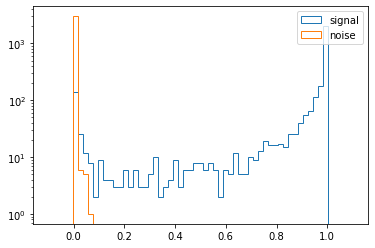

In [ ]:
plt.hist(y_p[y_test==1], range=(-0.1,1.1), bins=61, histtype='step', label='signal')
plt.hist(y_p[y_test==0], range=(-0.1,1.1), bins=61, histtype='step', label='noise')
plt.yscale('log')
plt.legend()
plt.savefig(model_dir_name+model_tag+'NNout.png')

In [ ]:
accs = []
#Loop through a list (100) of predictions of 6000 events
for y_p in mc_predictions:
    # Accuracy for a prediction of 6,000 events
    acc = accuracy_score(y_test, y_p.round())
    accs.append(acc)
print("MC accuracy: {:.2%}".format(sum(accs)/len(accs)))

MC accuracy: 95.03%


In [ ]:
#Average over 100 evalutaions to an array of 6,000 events:
mc_ensemble_pred = np.array(mc_predictions).mean(axis=0)
#Compare to 6,000 labels
ensemble_acc = accuracy_score(y_test, mc_ensemble_pred.round())
print("MC-ensemble accuracy: {:.2%}".format(ensemble_acc))

MC-ensemble accuracy: 95.82%


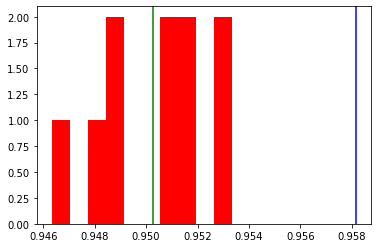

In [ ]:
plt.hist(accs, color='r');
plt.axvline(x=ensemble_acc, color="b");
plt.axvline(x=sum(accs)/len(accs), color="g");
plt.savefig(model_dir_name+model_tag+'ensemble_acc.png')

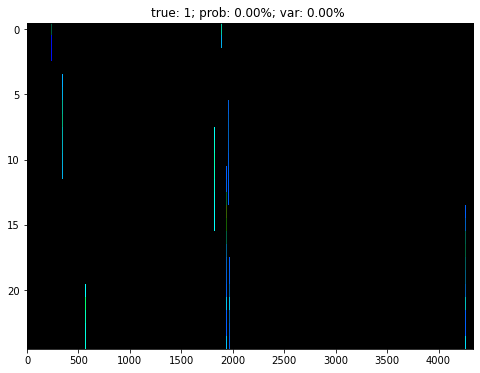

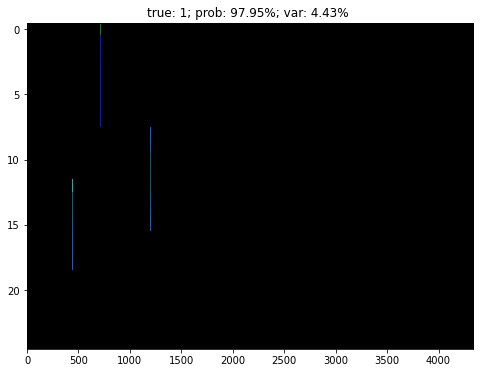

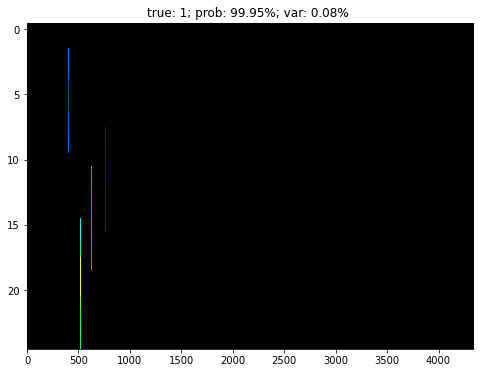

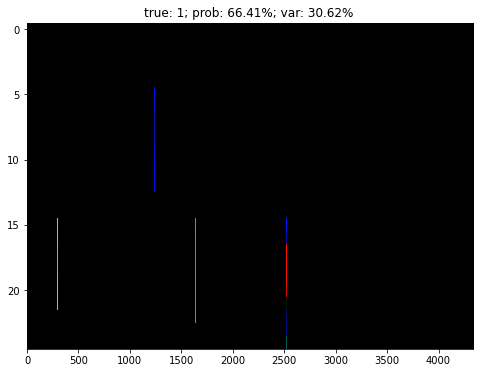

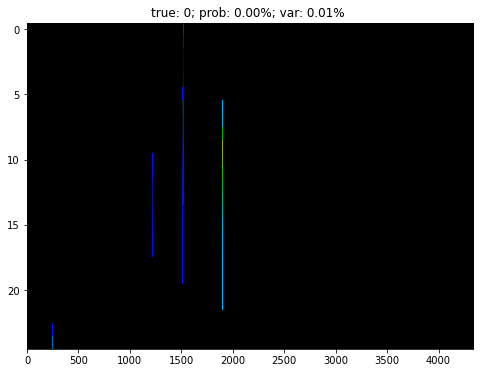

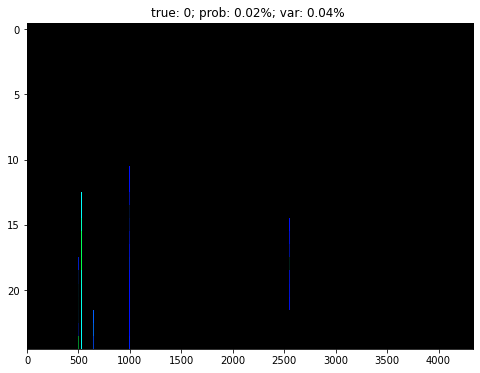

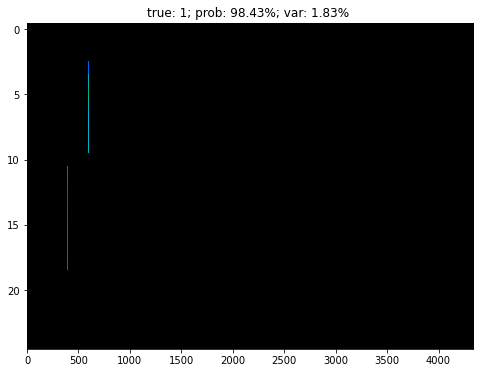

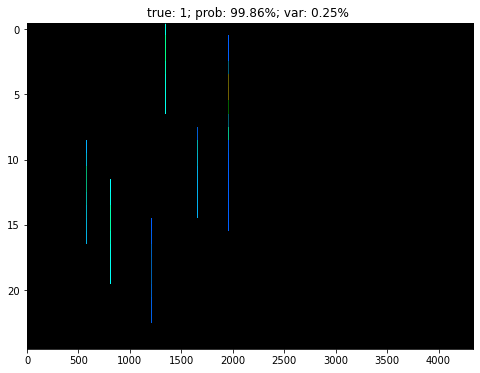

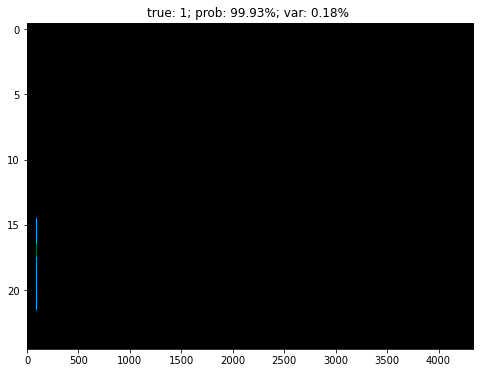

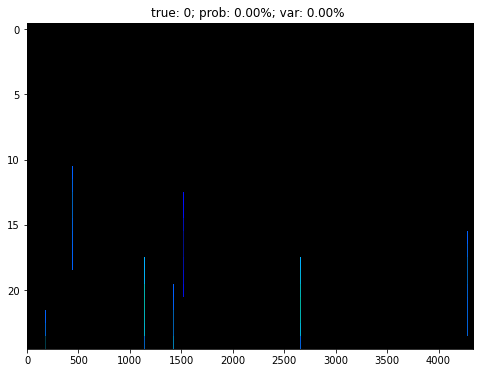

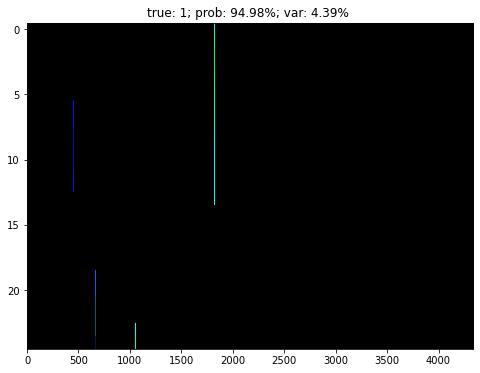

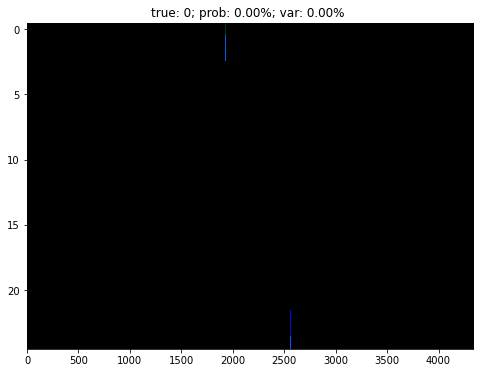

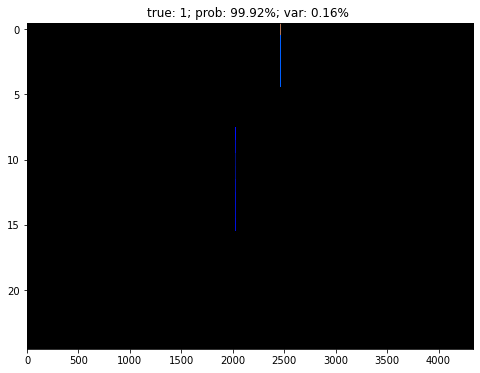

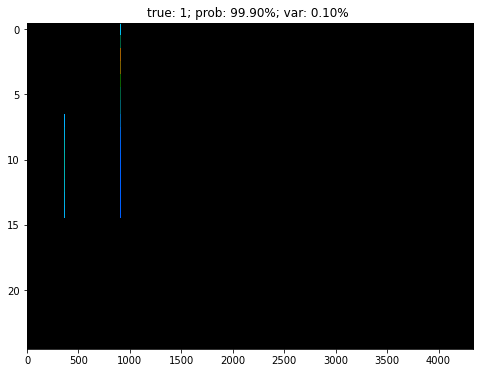

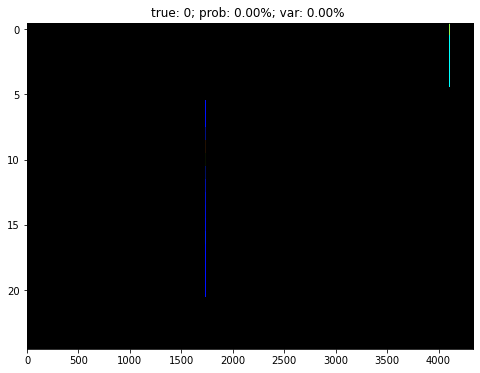

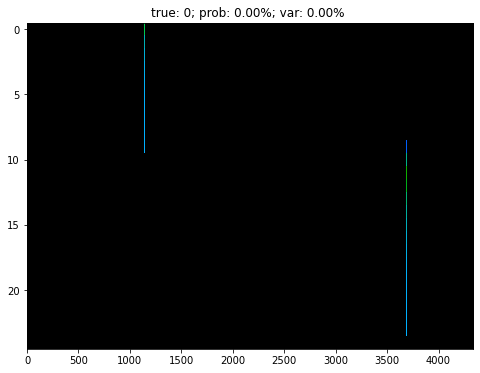

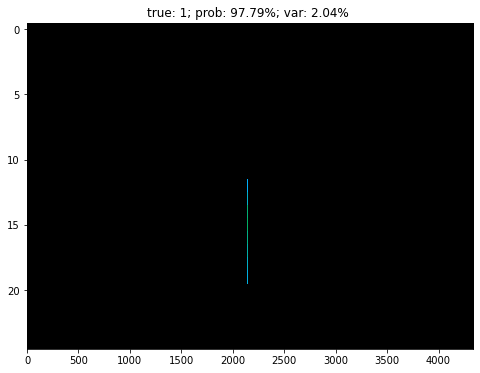

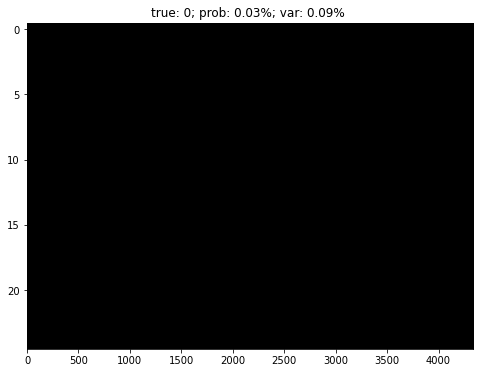

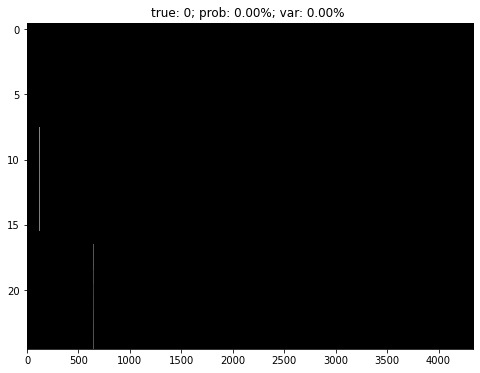

In [ ]:
for idx in range(1,20):
  p0 = np.array([p[idx] for p in mc_predictions])
  for i, (prob, var) in enumerate(zip(p0.mean(axis=0), p0.std(axis=0))):
    plt.figure(figsize=(8, 6))
    plt.imshow(X_test[idx], aspect='auto', interpolation='none')
    plt.title("true: {}; prob: {:.2%}; var: {:.2%} ".format(int(y_test[idx]), prob, var))
    plt.savefig(model_dir_name+'event_display_'+model_tag+str(idx)+'.png')

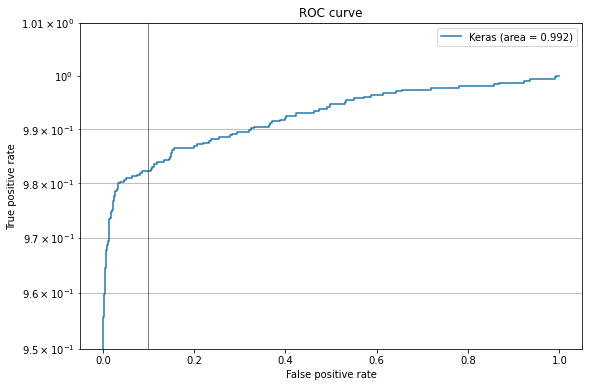

In [ ]:
from sklearn.metrics import roc_curve, auc
y_pred = loaded_model.predict(X_test)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test.ravel(), y_pred.ravel())
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(figsize=(9, 6))
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(tpr_keras, fpr_keras,  label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.yscale('log')
plt.ylim(0.95,1.01)
plt.axvline(0.1, color='black', lw=0.5)
plt.grid(which='minor')
plt.savefig(model_dir_name+model_tag+'ROC_curve.png')

In [ ]:
np.interp(0.9, tpr_keras, fpr_keras)

0.0016784155756965425

In [ ]:
fpr_keras.searchsorted(0.5, 'left')

251

In [ ]:
tpr_keras.size

519

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline


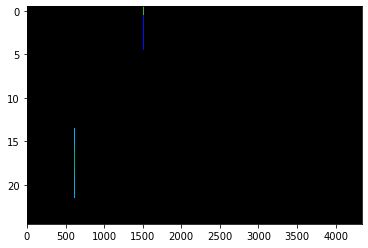

In [ ]:
idx = 250
plt.imshow(X_test[idx], aspect='auto', interpolation='none')

In [ ]:
plt.hist(accs);
plt.axvline(x=ensemble_acc, color="b");

#Produce event displays

Found 100 images belonging to 2 classes.
0 0.0 [[0.00024581]]
50 1.0 [[0.7898098]]
1 0.0 [[0.00461083]]
51 1.0 [[0.89527845]]
2 0.0 [[0.00666594]]
52 1.0 [[0.97607416]]
3 0.0 [[0.79831624]]
53 1.0 [[0.9603009]]
4 0.0 [[0.03504414]]
54 1.0 [[0.9920163]]
5 0.0 [[0.00412502]]
55 1.0 [[0.9906345]]
6 0.0 [[0.00026173]]
56 1.0 [[0.96291]]
7 0.0 [[0.00031355]]
57 1.0 [[0.97735137]]
8 0.0 [[0.02064338]]
58 1.0 [[0.9936359]]
9 0.0 [[0.06303909]]
59 1.0 [[0.9905641]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


10 0.0 [[0.08333016]]
60 1.0 [[0.9439533]]
11 0.0 [[0.01113855]]
61 1.0 [[0.9902201]]
12 0.0 [[0.00540274]]
62 1.0 [[0.9933176]]
13 0.0 [[0.00461822]]
63 1.0 [[0.758146]]
14 0.0 [[0.00513906]]
64 1.0 [[0.97351664]]
15 0.0 [[0.01216921]]
65 1.0 [[0.856636]]
16 0.0 [[0.00548422]]
66 1.0 [[0.99561065]]
17 0.0 [[0.9947242]]
67 1.0 [[0.9973847]]
18 0.0 [[0.17958017]]
68 1.0 [[0.9967474]]
19 0.0 [[0.00288374]]
69 1.0 [[0.99595463]]


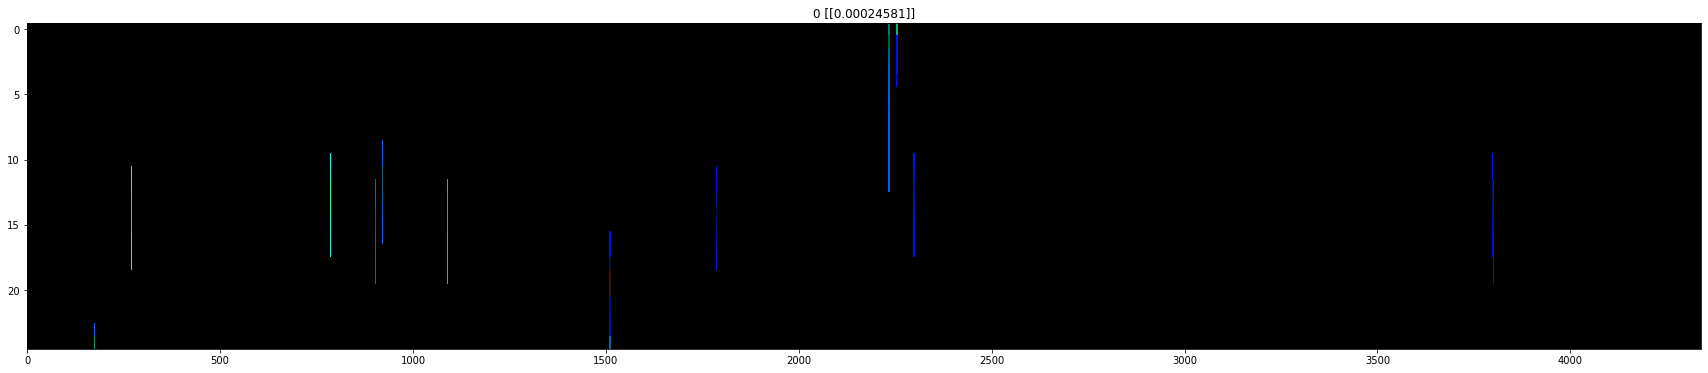

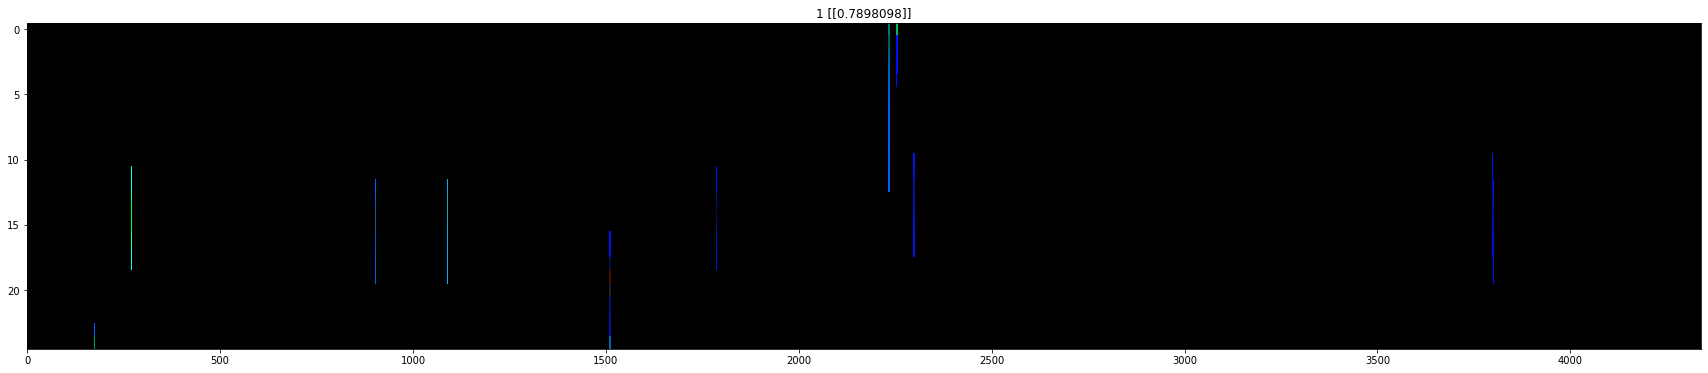

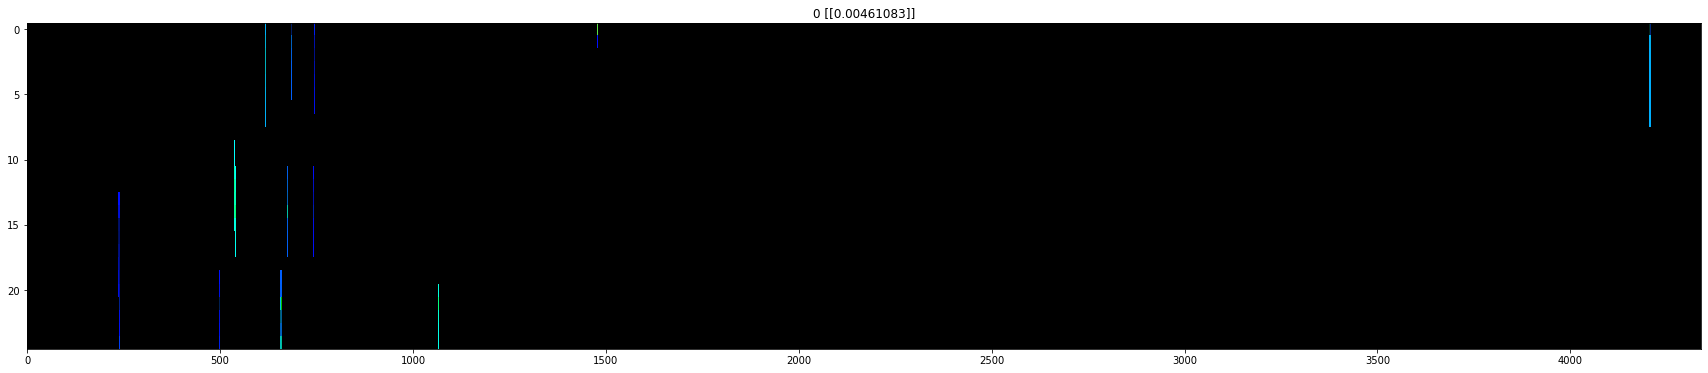

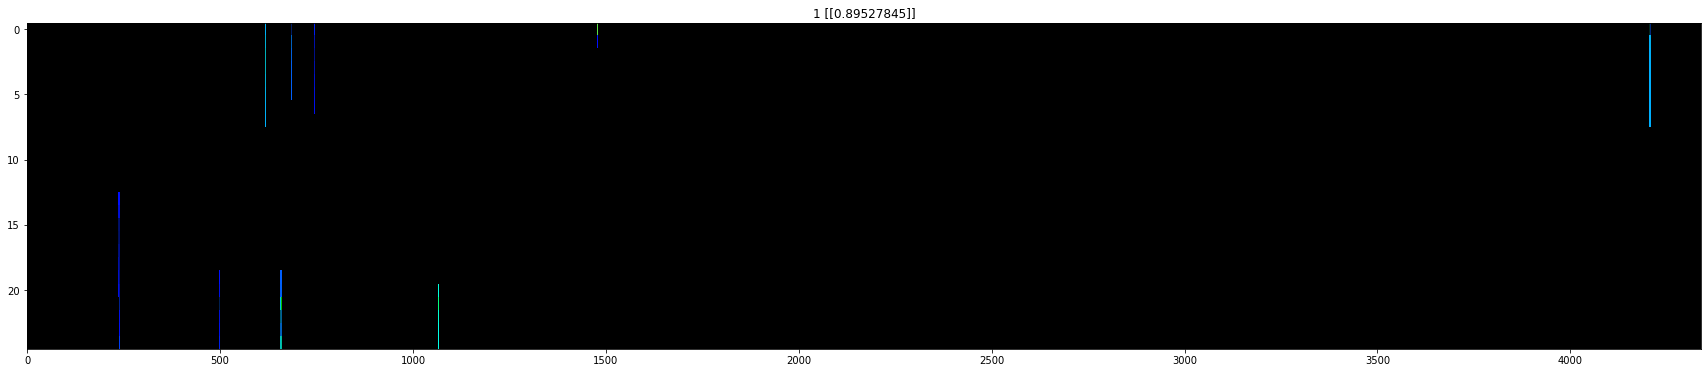

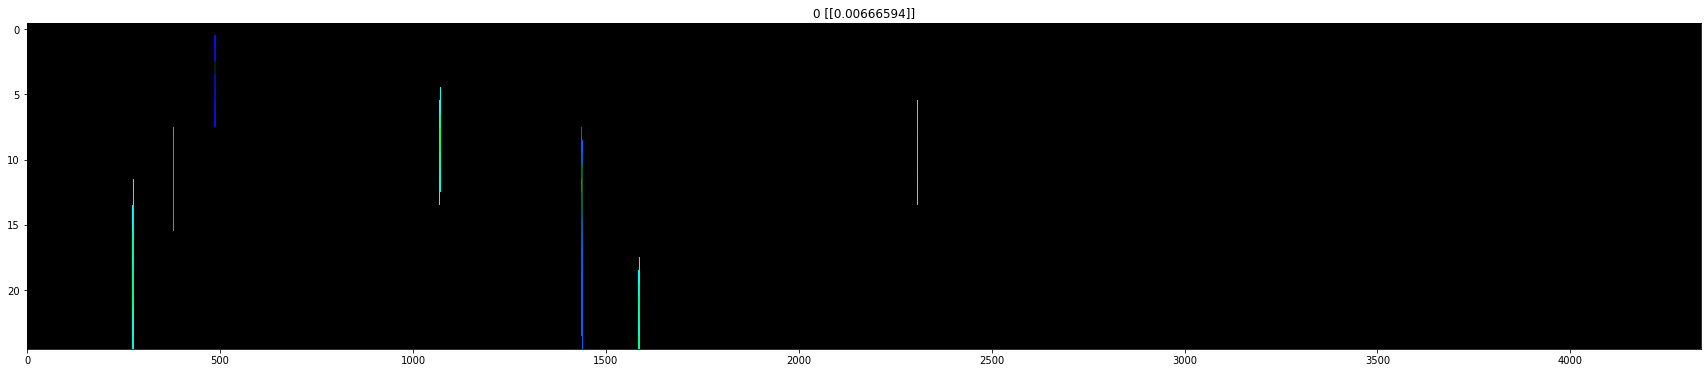

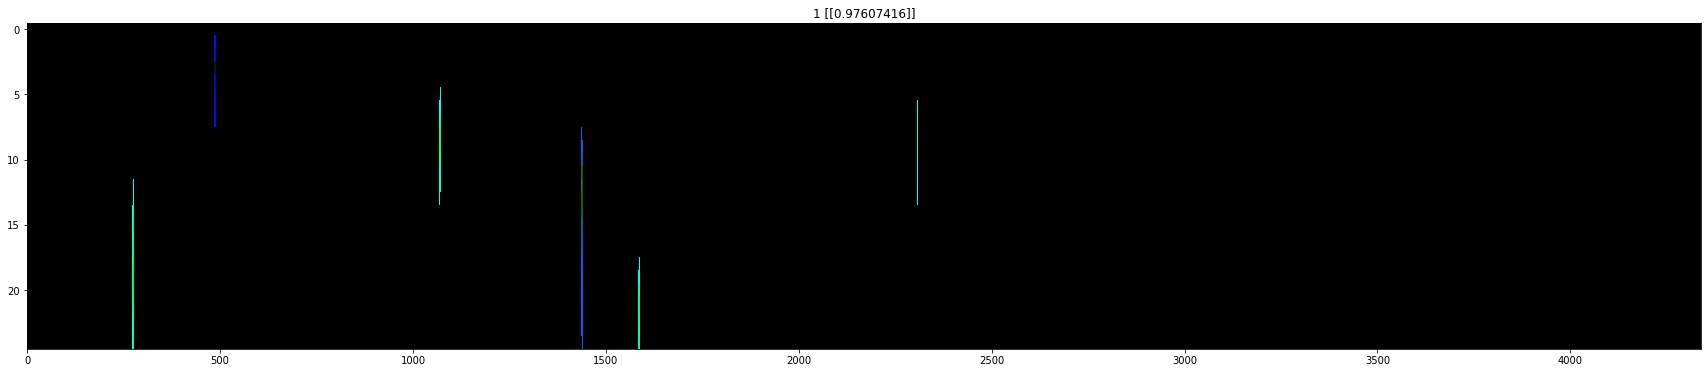

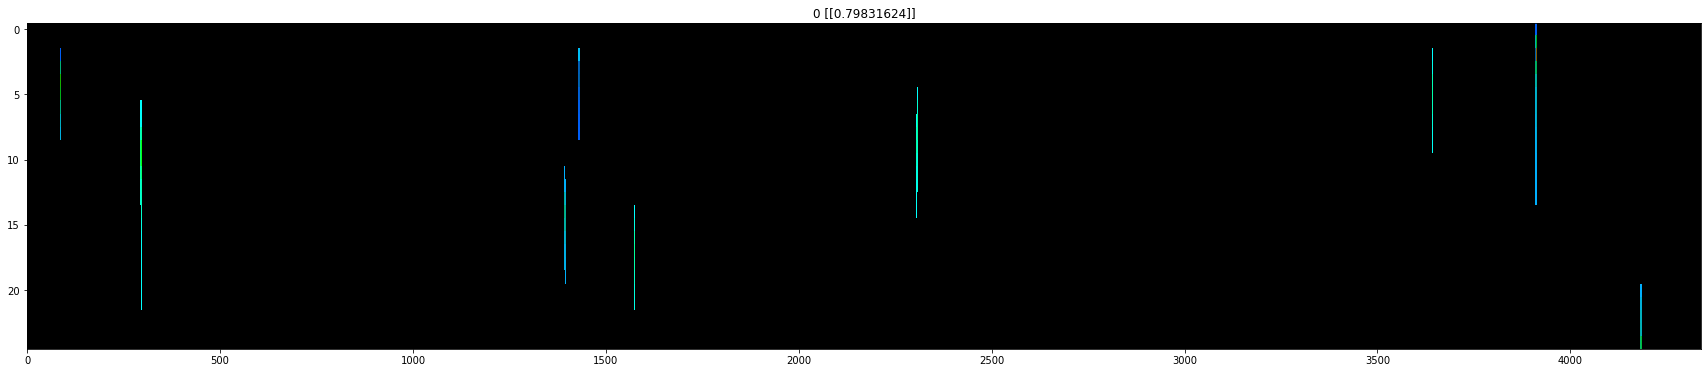

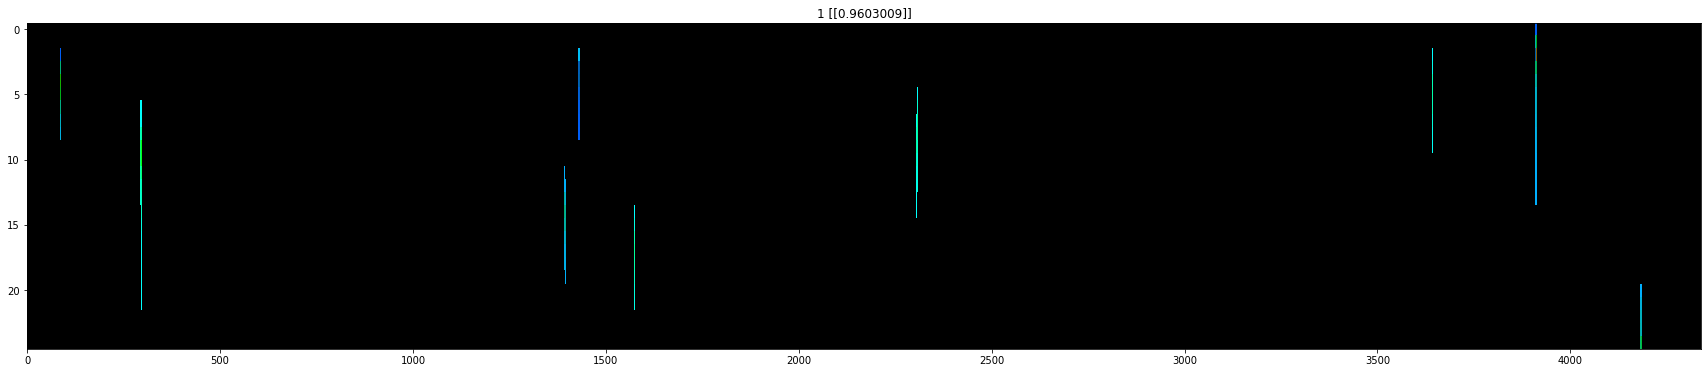

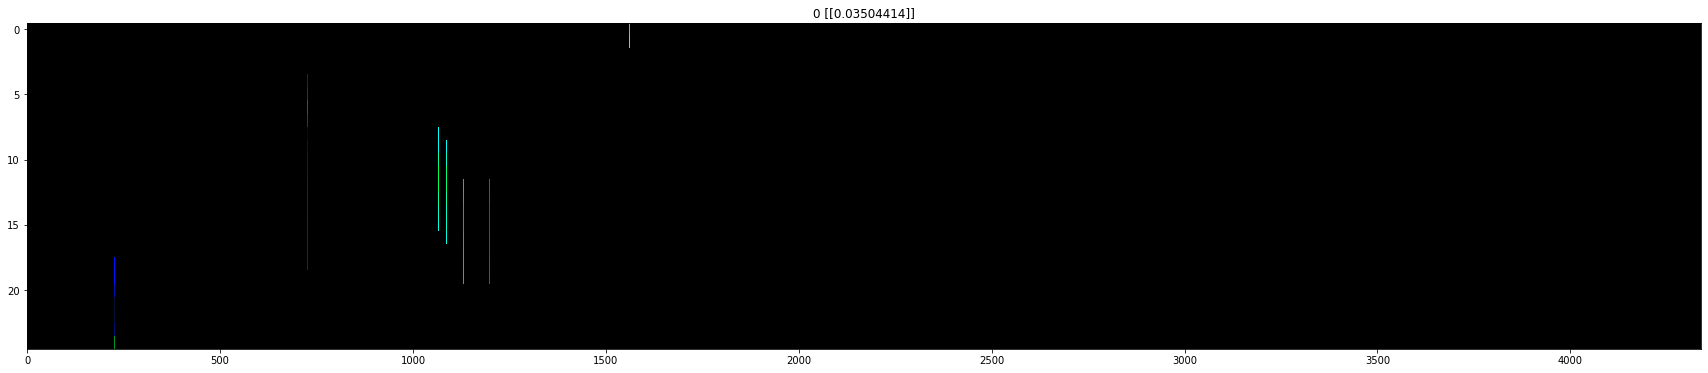

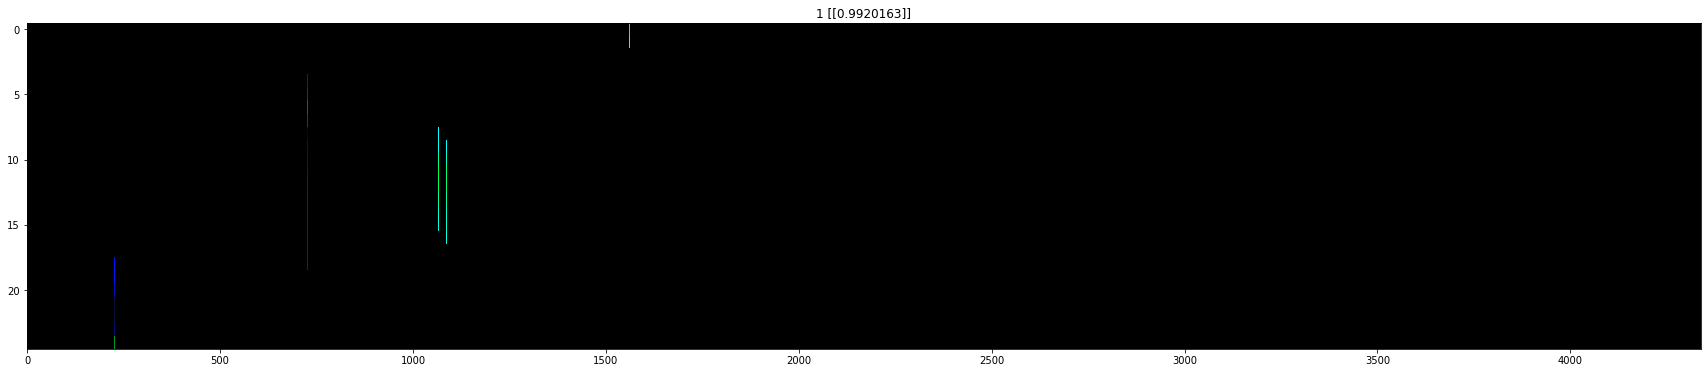

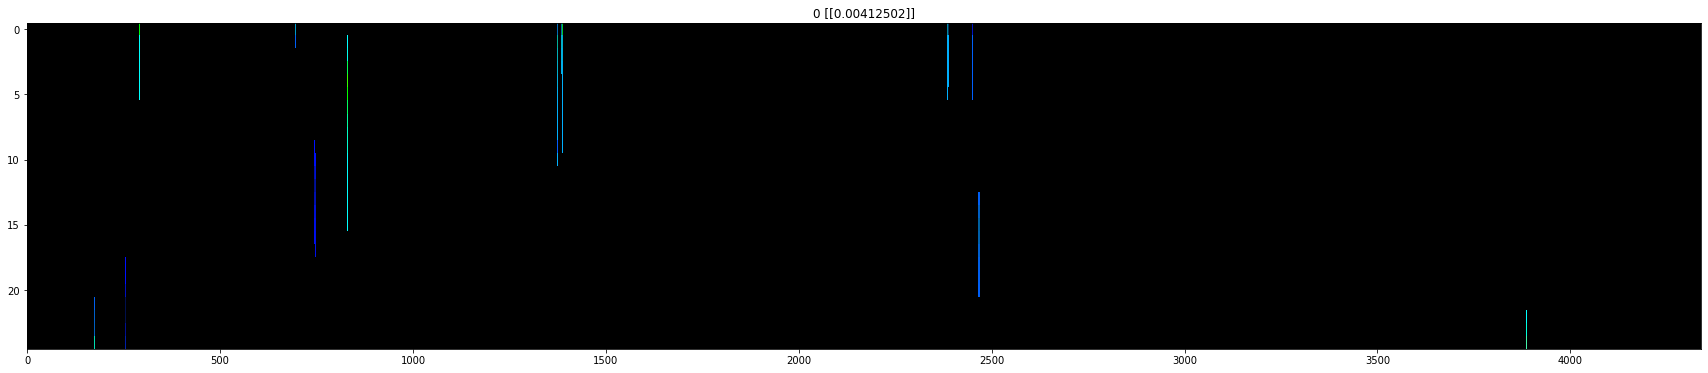

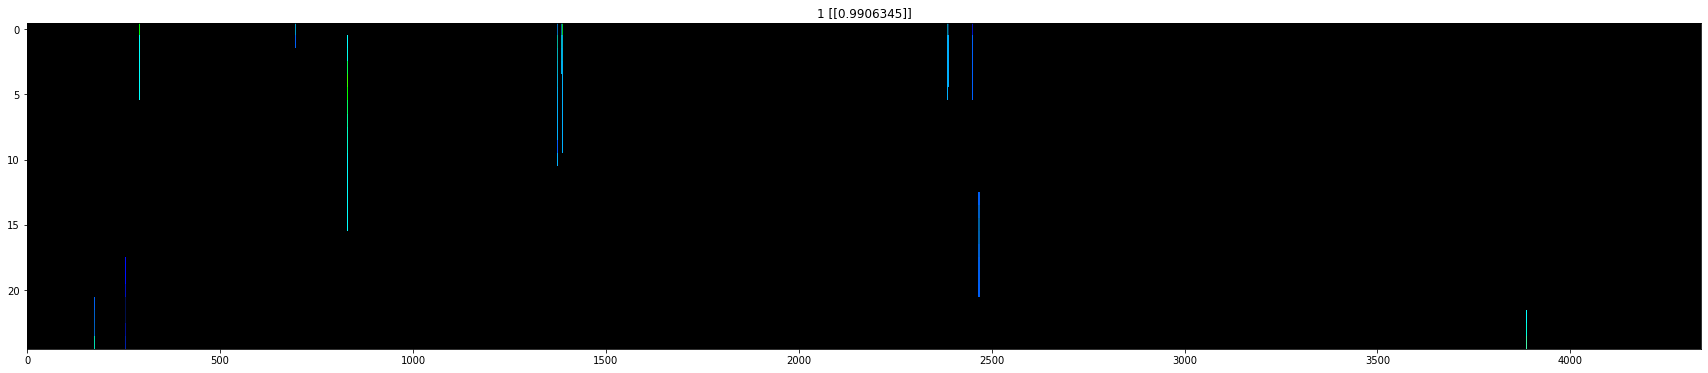

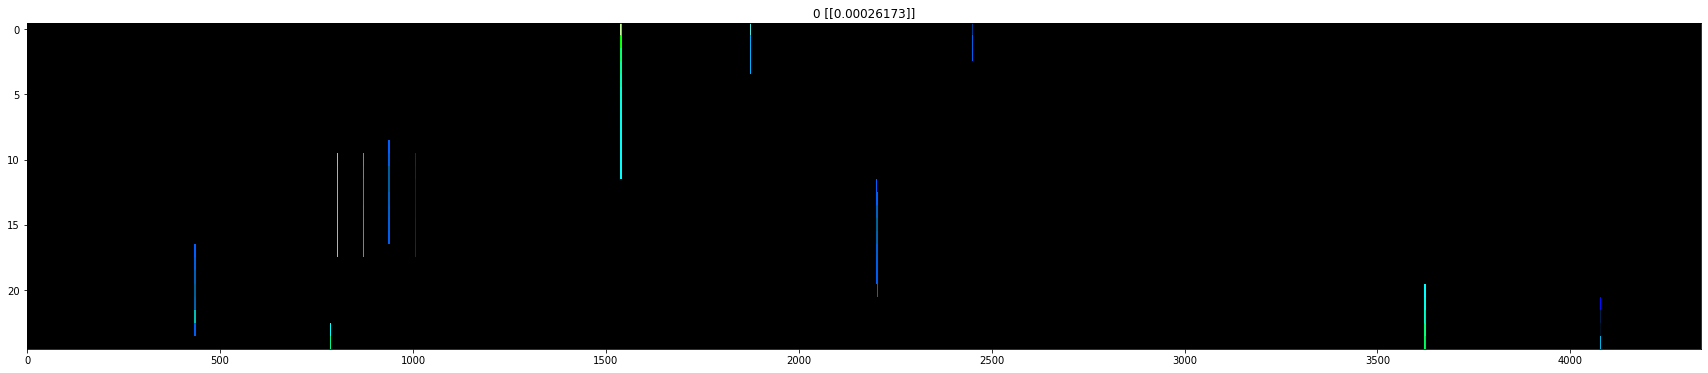

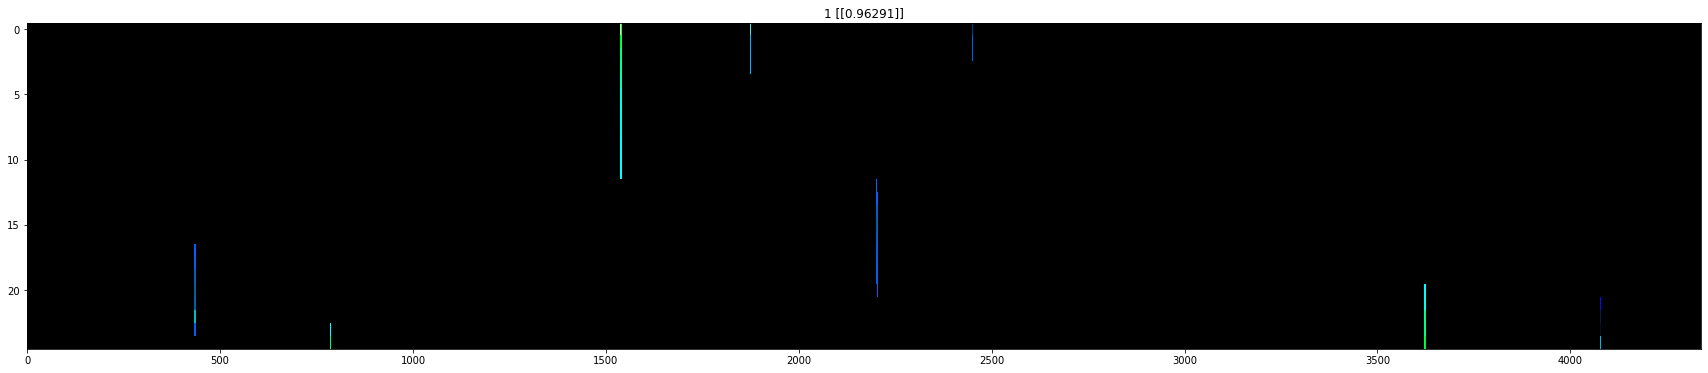

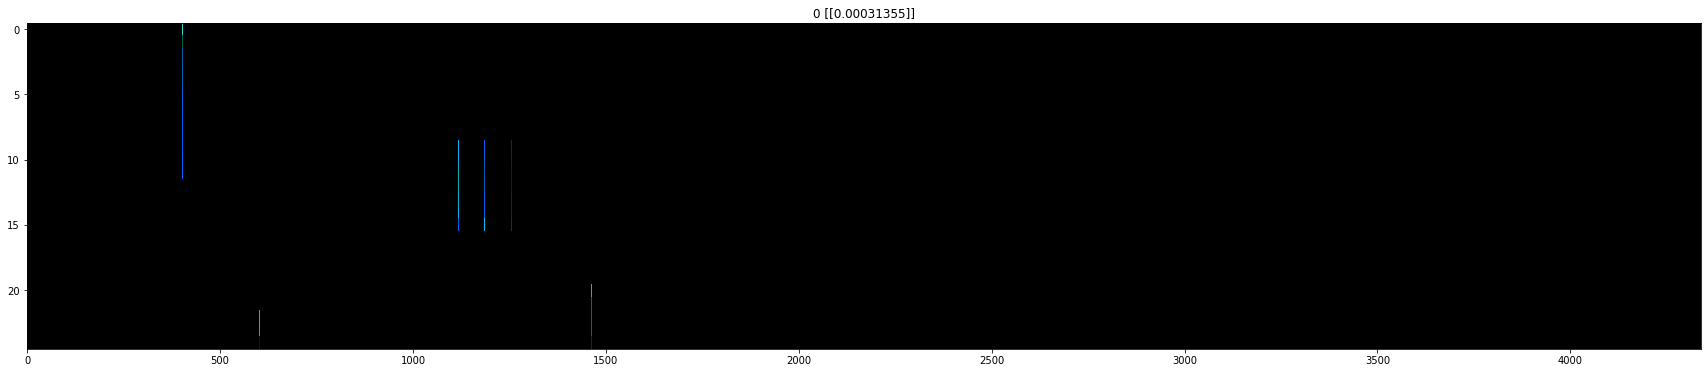

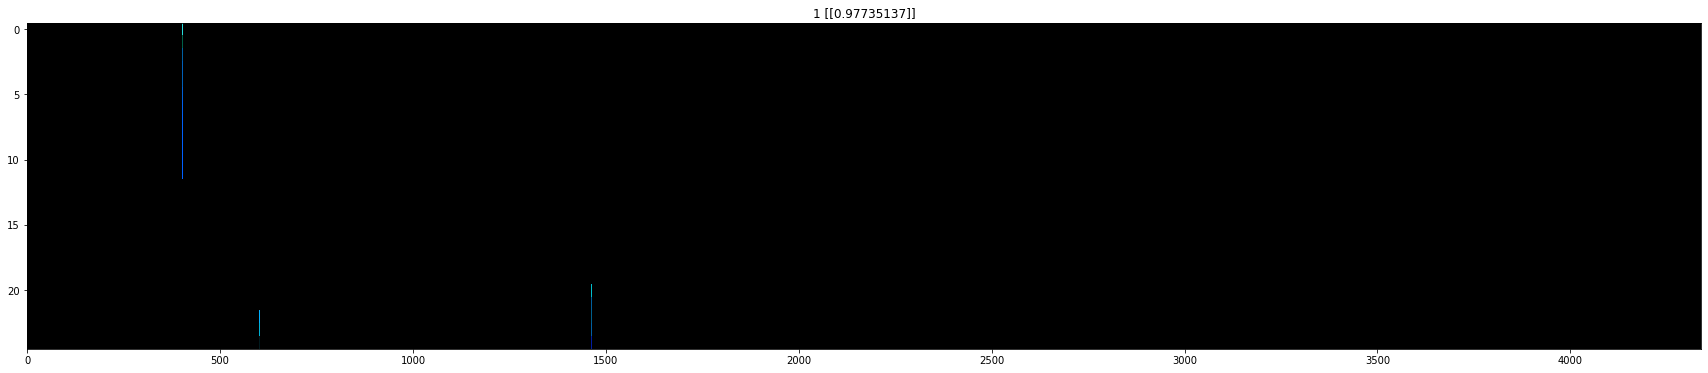

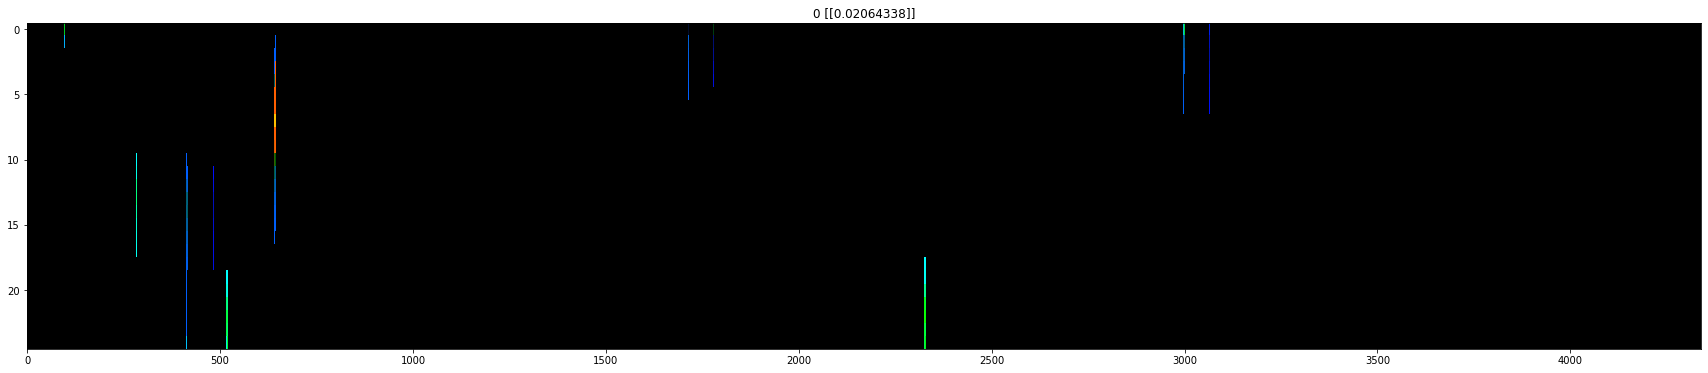

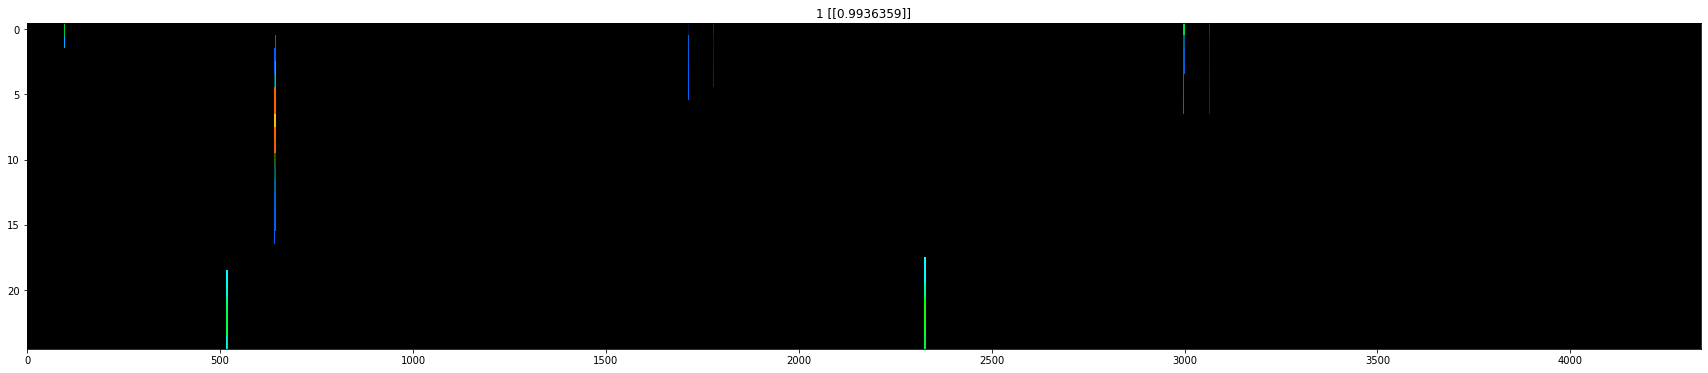

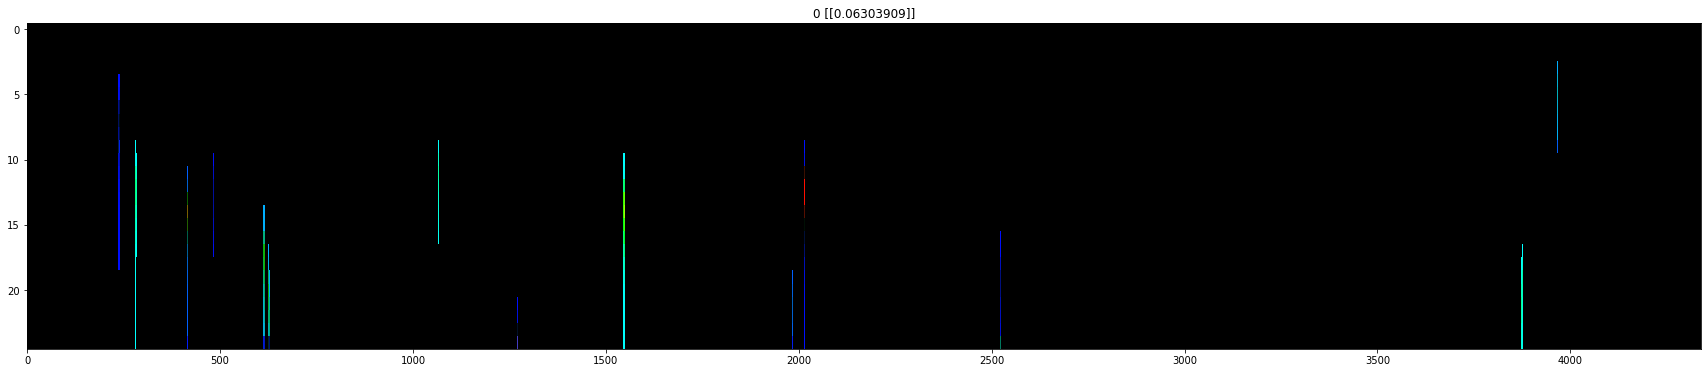

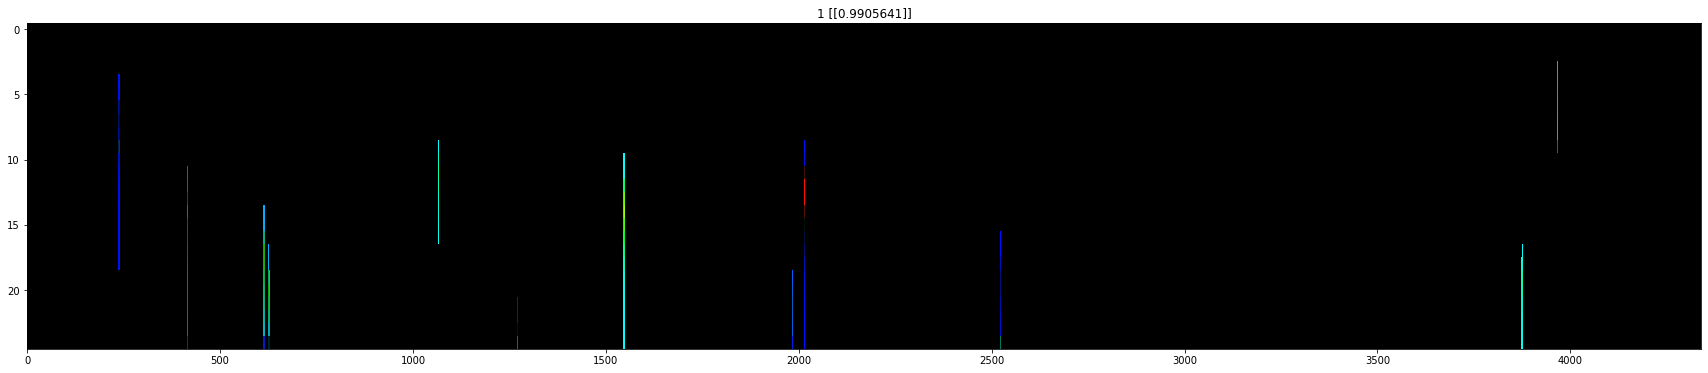

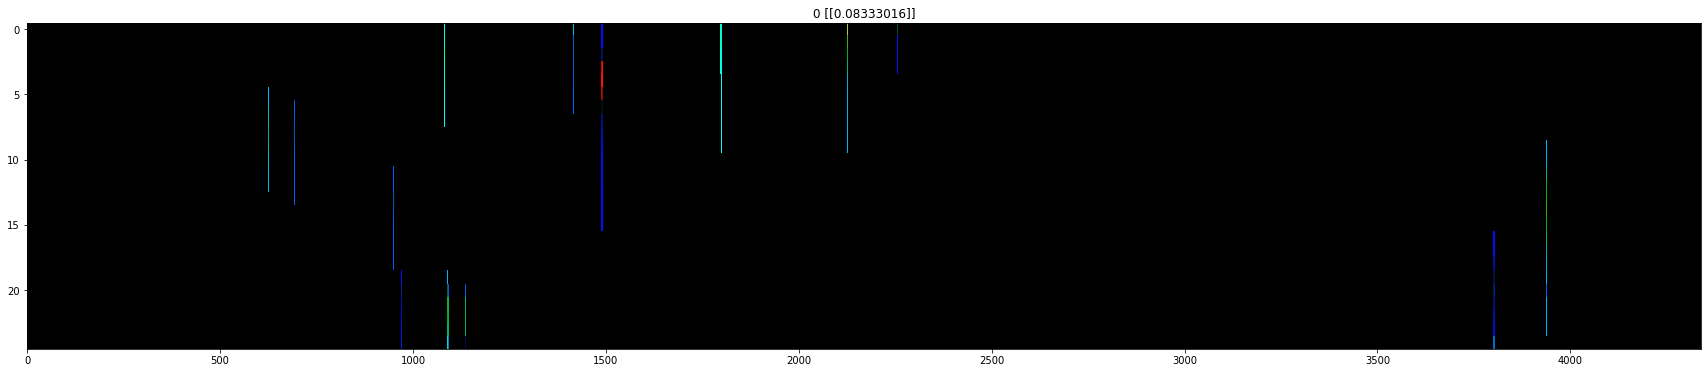

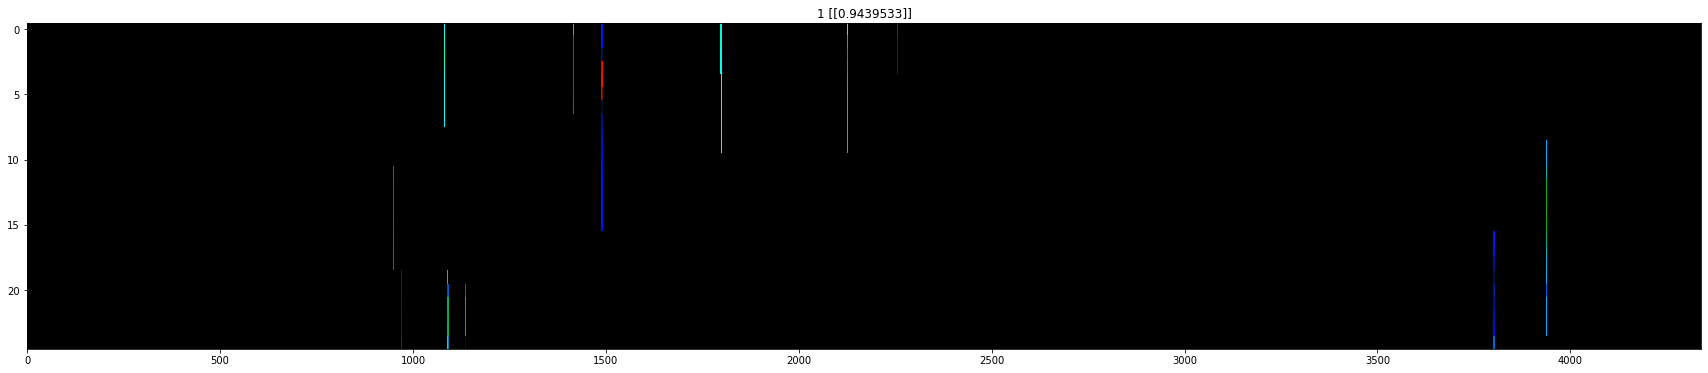

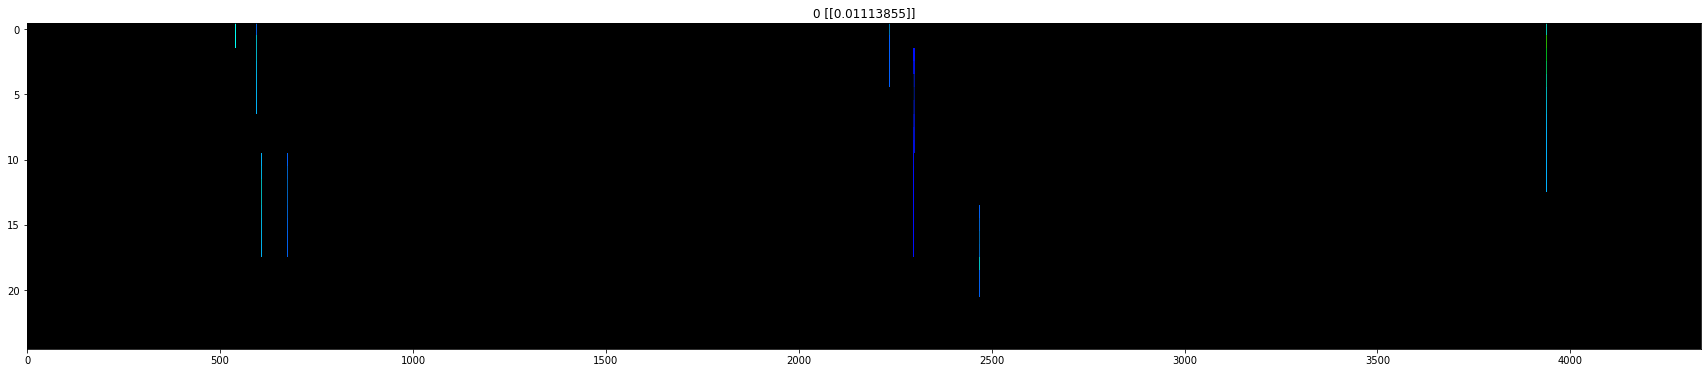

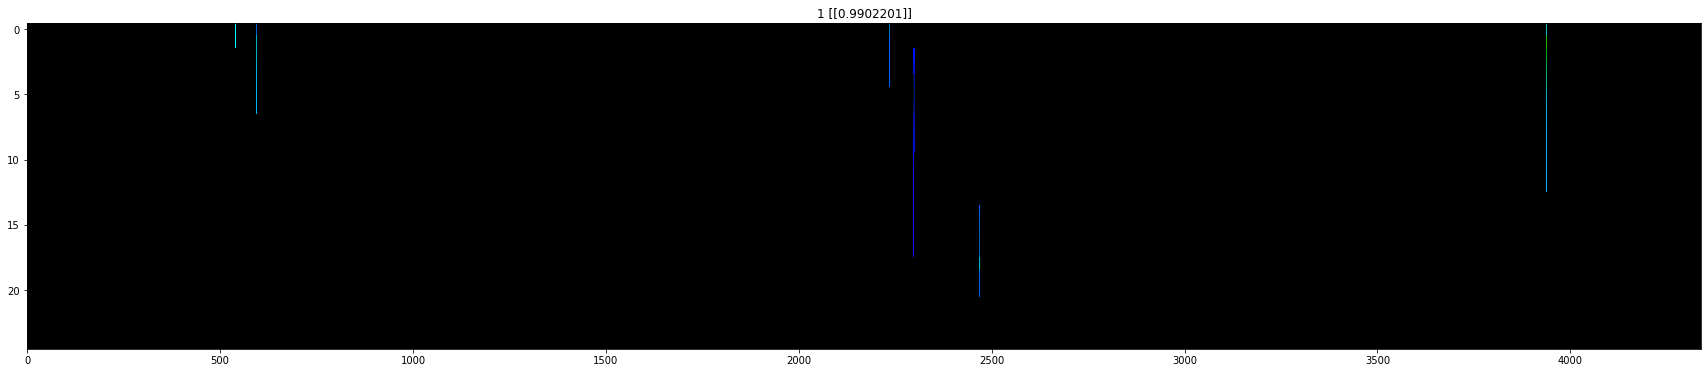

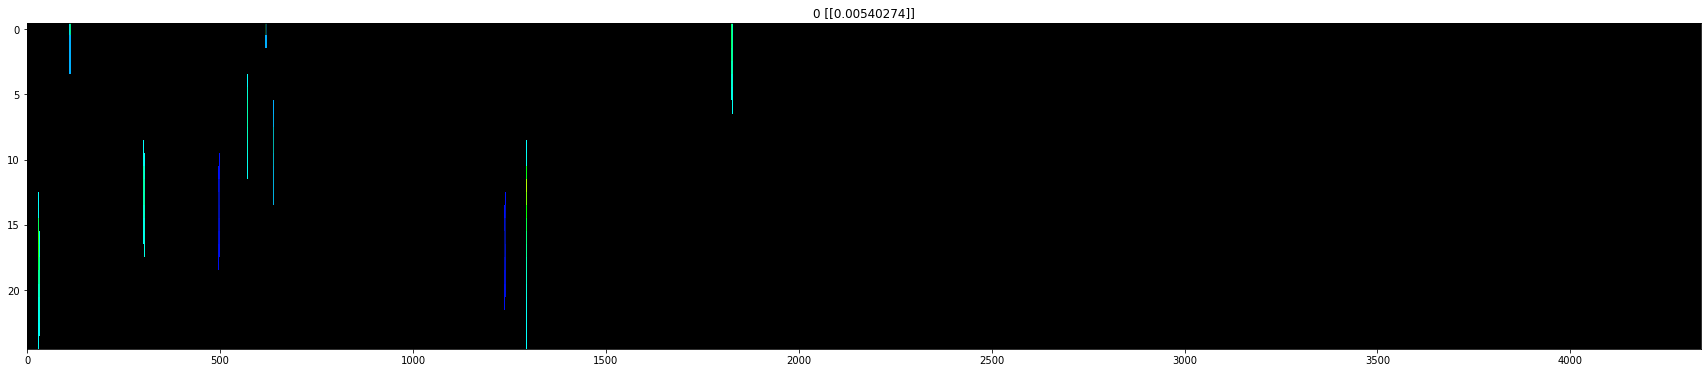

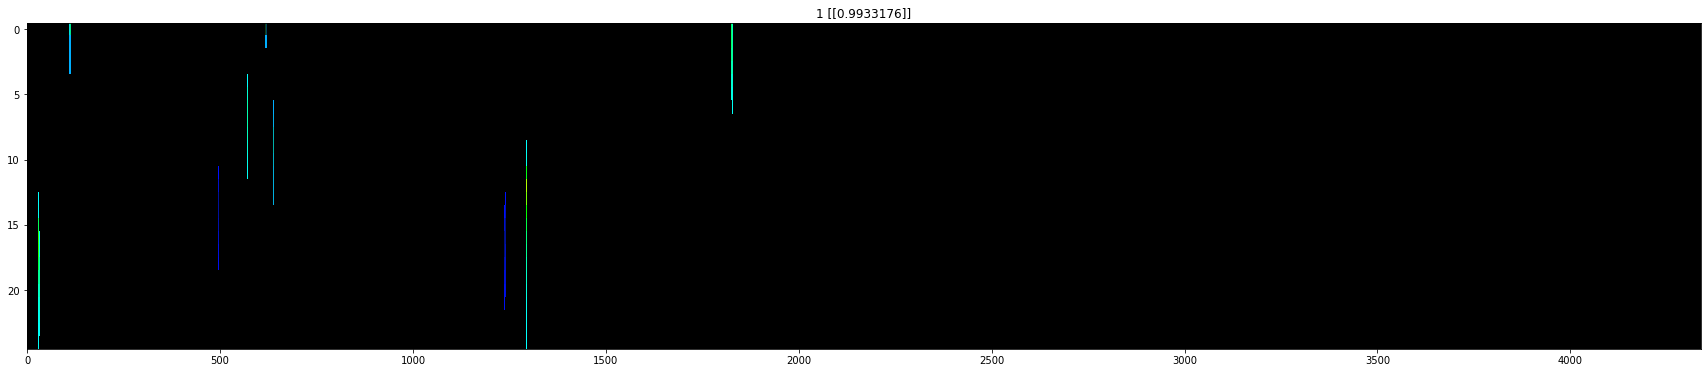

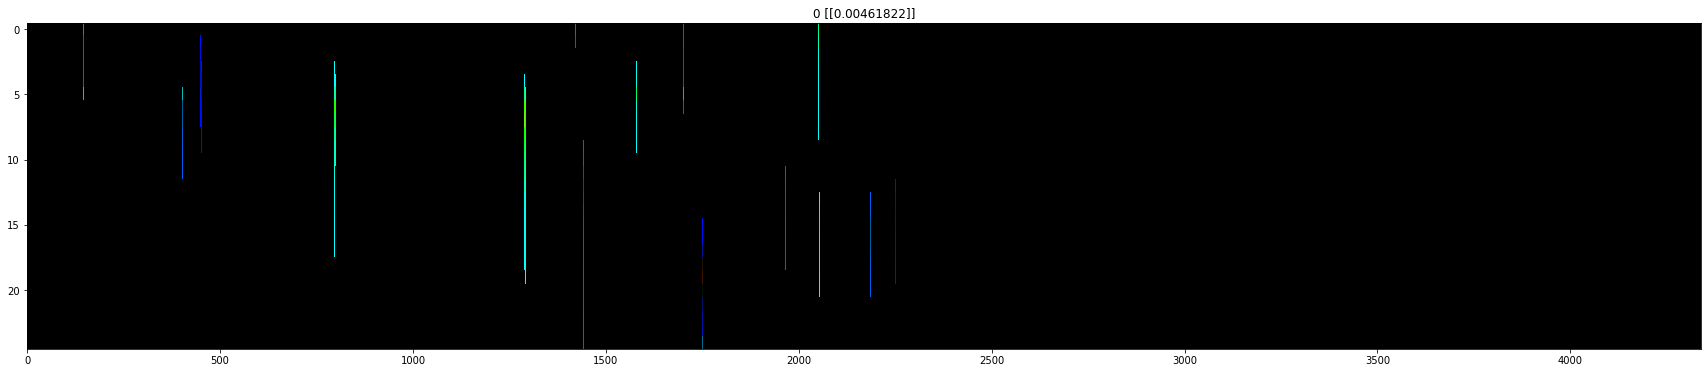

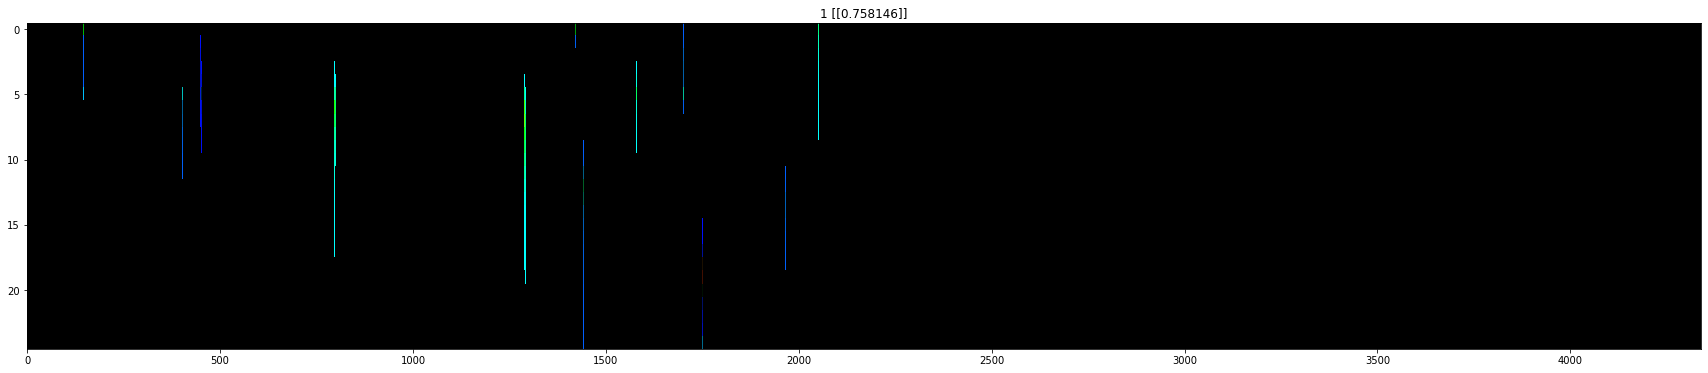

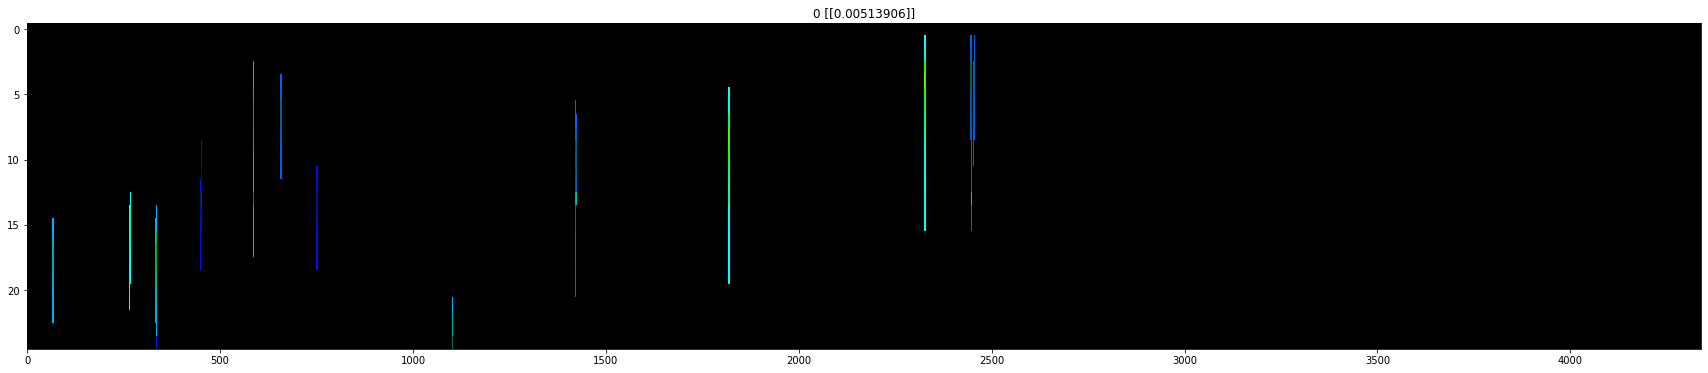

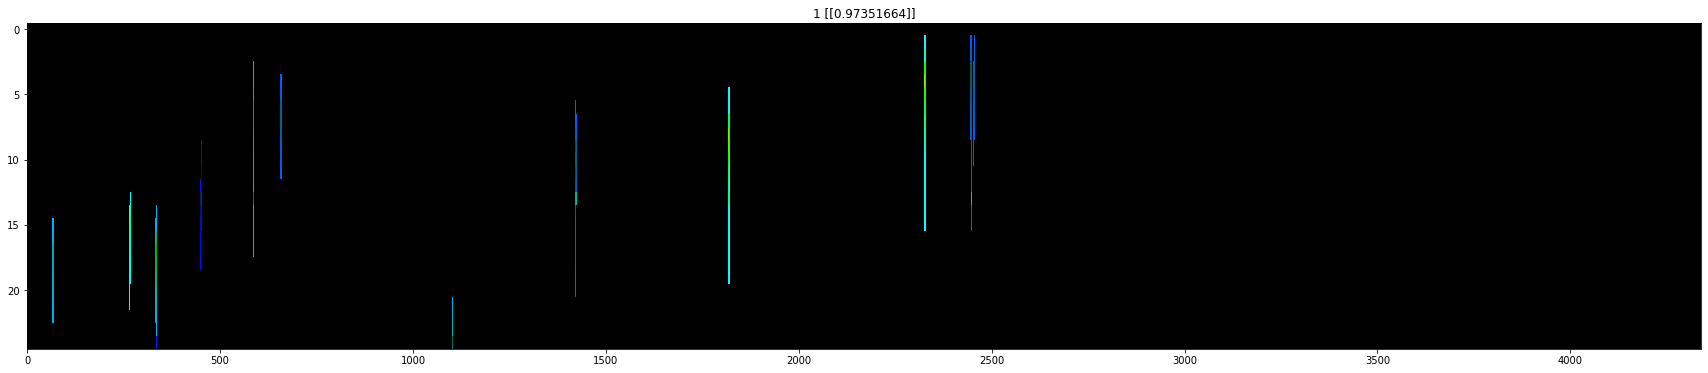

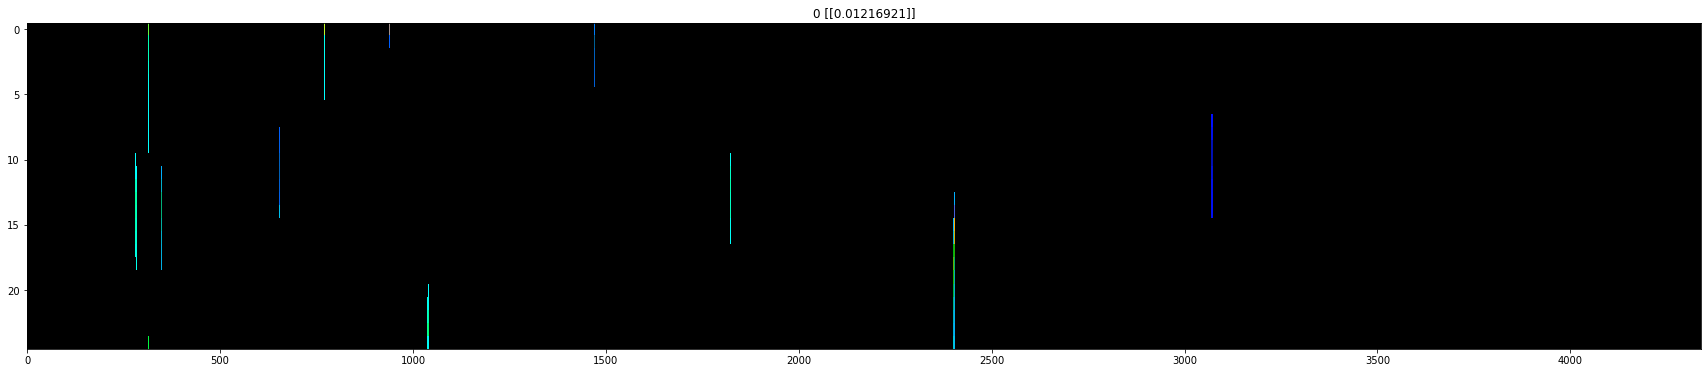

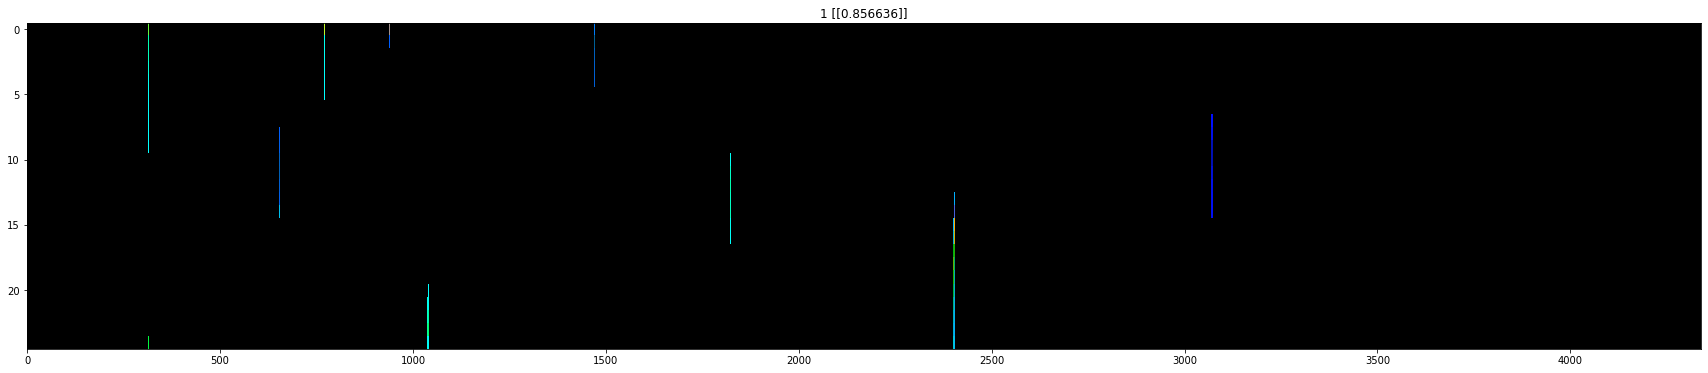

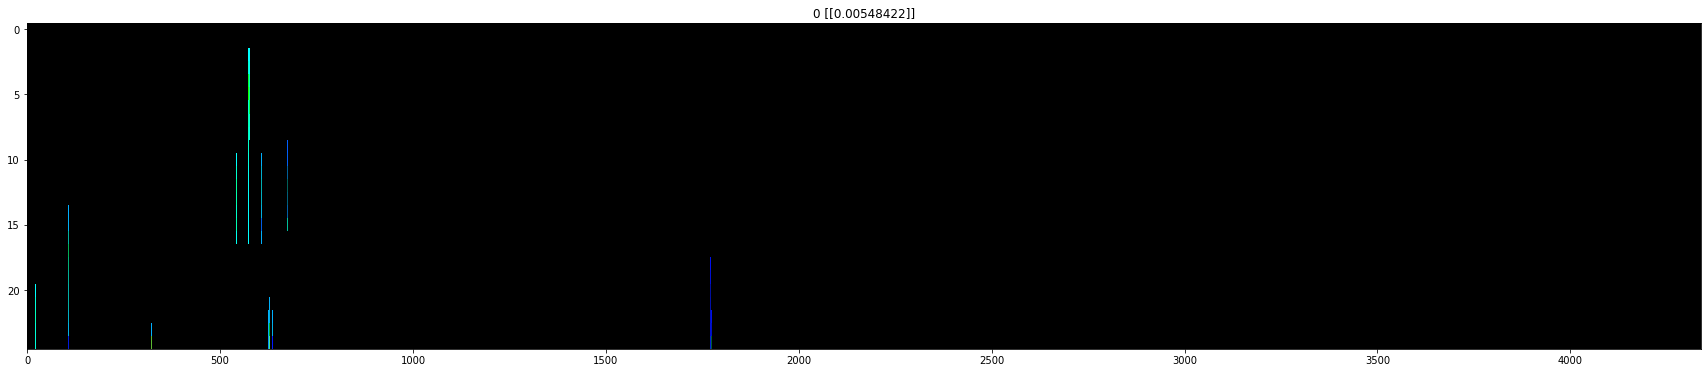

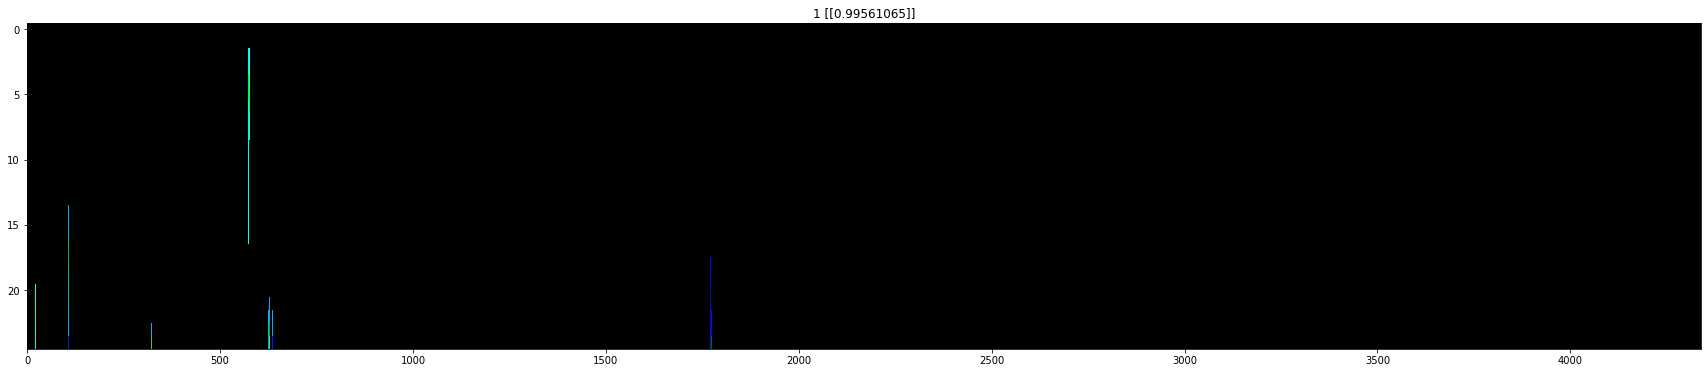

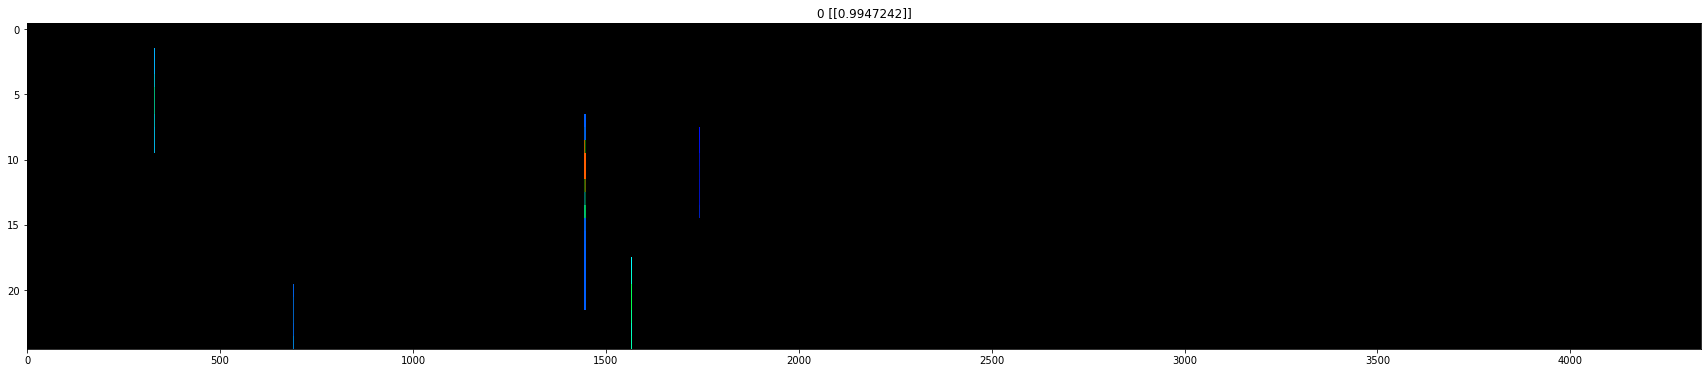

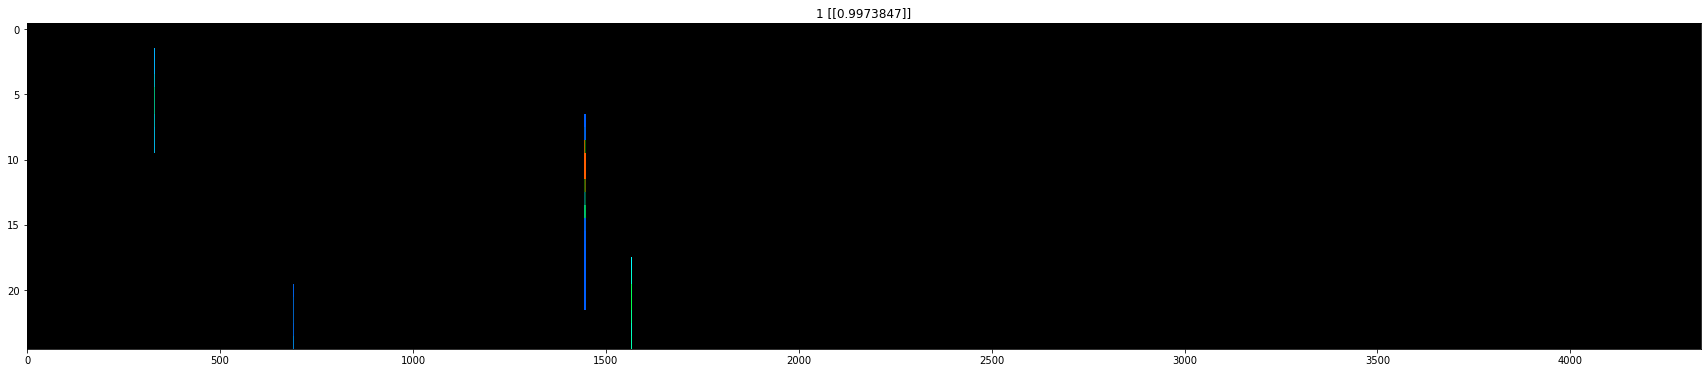

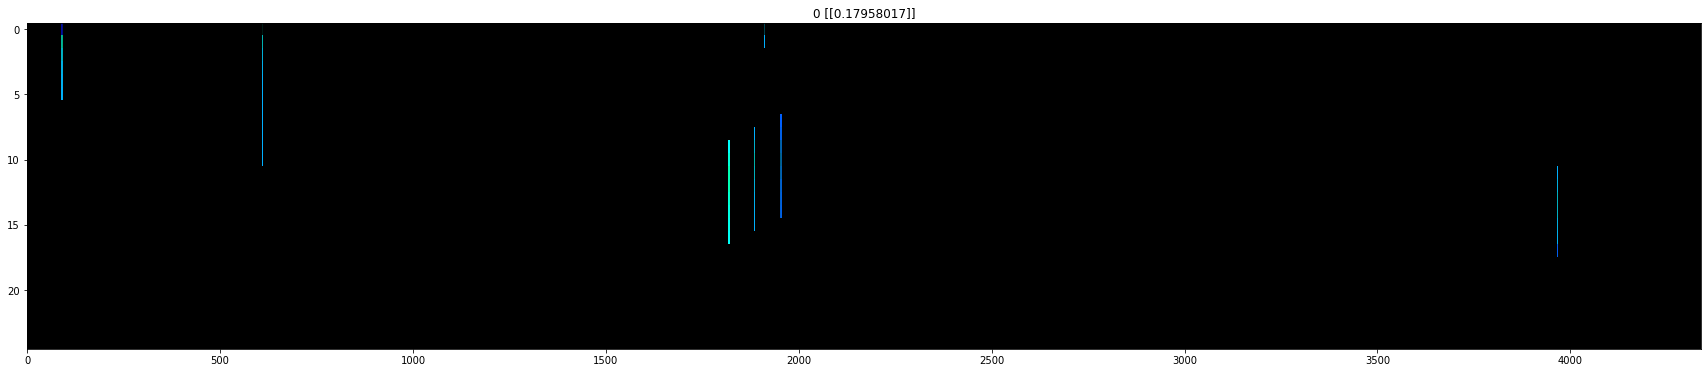

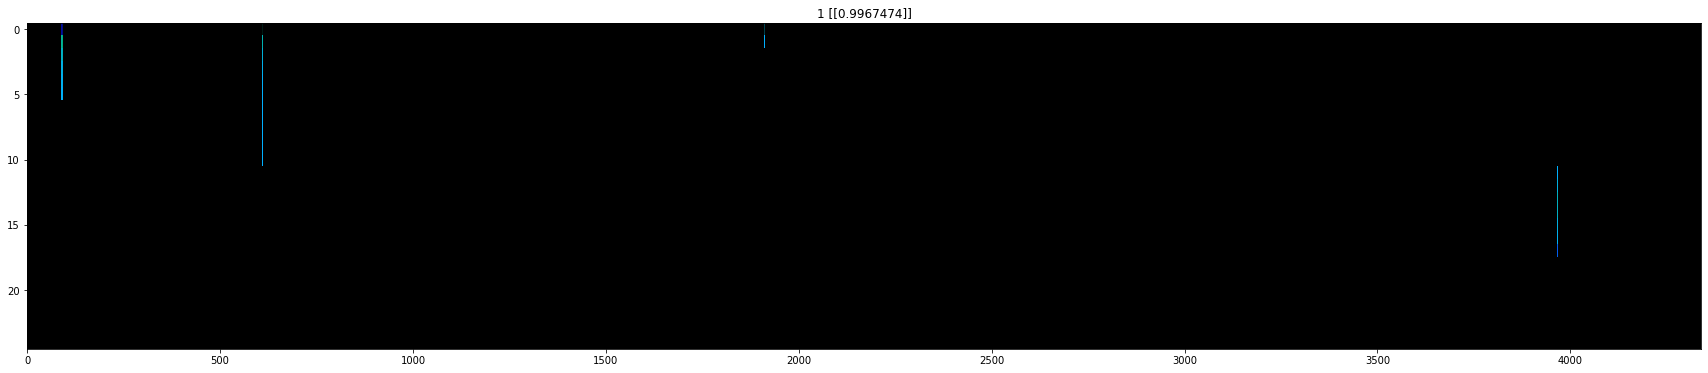

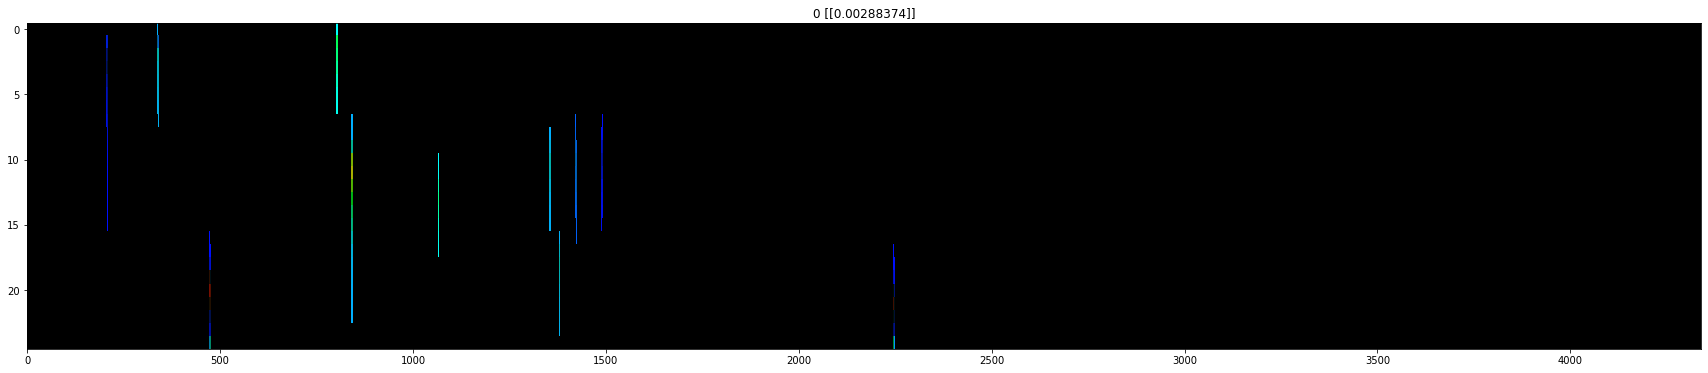

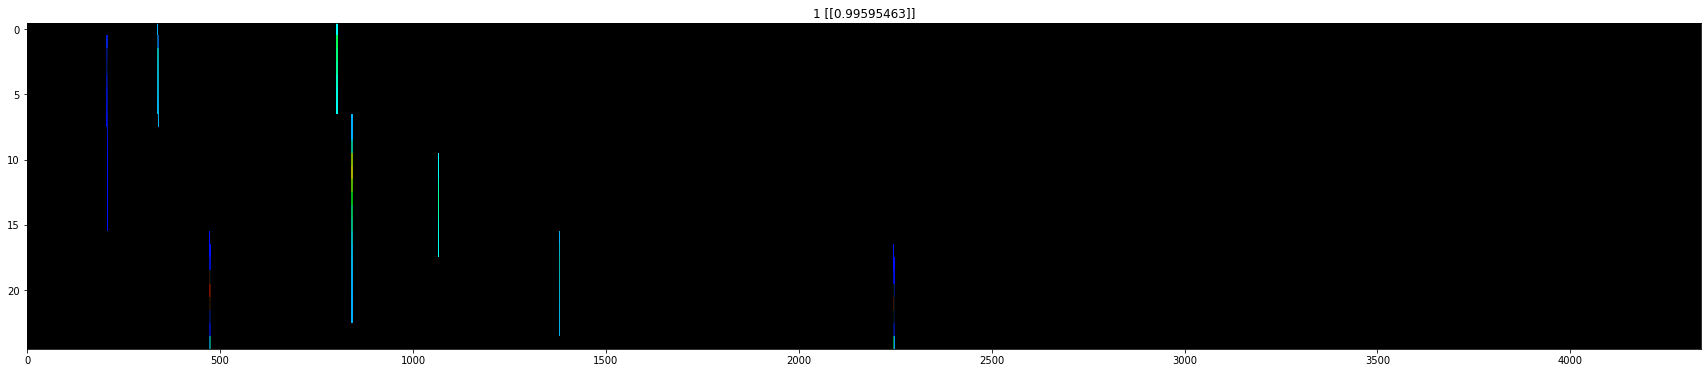

In [ ]:
#Make sure the events are not shuffled
n_images = 100
datagen_image = ImageDataGenerator(validation_split=0.001, rescale=1./255)
image_it = datagen_image.flow_from_directory('/content/ImagesCNN/', class_mode='binary', batch_size=n_images, shuffle=False, color_mode="rgb", target_size=image_size, subset='validation')
X_image, y_image = next(image_it)

for eve in range(0,20):

  indx = eve
  plt.figure(figsize=(30, 6))
  plt.imshow(X_image[eve], aspect='auto', interpolation='none')
  X_image_ = np.expand_dims(X_image[indx], axis=0)
  prob = loaded_model.predict(X_image_)

  print(indx, y_image[bg_idx], prob)
  plt.title(str(int(y_image[indx]))+' '+str(prob))

#  plt.xlim(0,2000)

  plt.figure(figsize=(30, 6))
  indx = eve+int(n_images/2)
  plt.imshow(X_image[indx], aspect='auto', interpolation='none')
  X_image_ = np.expand_dims(X_image[indx], axis=0)
  prob = loaded_model.predict(X_image_)
  plt.title(str(int(y_image[indx]))+' '+str(prob))
  print(indx, y_image[indx], prob)
#  plt.xlim(0,2000)

In [ ]:
y_image

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
X_image.shape

(10, 25, 4339, 3)

#Testing and Examining Failed Events

In [ ]:
#Load data that was not used in training for testing purposes
#By convention data files with batch numbers >= 40 are reserved for testing

#Record what batches have been used here so we don't repeat (thereby training on test data): 40
test_batch_num = 40

X1, X2, y1, y2 = get_data(test_batch_num)

X_test = np.concatenate((X1,X2)) #Test on the full file contents, undo the train test split
y_test = np.concatenate((y1,y2))

Processing file: /content/drive/My Drive/Mu2e/root_files_oksuzian/crvdata40.pkl
2000 108476


In [ ]:
#How does the model do?
testResults = model.evaluate(X_test, y_test)
print("Test loss, test accuracy: " + str(testResults))

63/63 [==============================] - 1s 22ms/step - loss: 0.0972 - accuracy: 0.9735
Test loss, test accuracy: [0.0972418338060379, 0.9735000133514404]


In [ ]:
predictions = model.predict(X_test)
predictions = predictions.squeeze()

In [ ]:
predictions

array([3.6667258e-05, 4.6684474e-04, 1.0000000e+00, ..., 1.2578520e-05,
       1.0000000e+00, 1.0000000e+00], dtype=float32)

In [ ]:
#Look at the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, np.round(predictions))
print("True Noise : False Noise")
print(confusion_matrix)
print("False Cosmic : True Cosmic")

True Noise : False Noise
[[984  16]
 [ 28 972]]
False Cosmic : True Cosmic


In [ ]:
#incorrectly_pred_imgs = X_test[predictions != y_test]
#print(str(incorrectly_pred_imgs.shape[0]) + " images were predicted incorrectly out of 2000")

1230 images were predicted incorrectly out of 2000


In [ ]:
incorrectly_pred_imgs = incorrectly_pred_imgs.squeeze() #Remove the third dimension (1)

In [ ]:
incorrect_indices = [i for i,p in enumerate(predictions) if predictions[i] != y_test[i]]

In [ ]:
#Plot an incorrectly classified image and what it was labeled as
def plotIncorrect(imgs, preds, inds, nImgs=1, startInd=0):
    for imgN in range(nImgs):
        if imgN + startInd > imgs.shape[0]:
            break

        predClass = ""
        trueClass = ""
        if preds.[inds[imgN + startInd]] == 1:
            predClass = "Noise"
            trueClass = "Cosmic"
        else:
            predClass = "Cosmic"
            trueClass = "Noise"
        print("Image was predicted to be " + predClass + " but is actually " + trueClass)
       
        plt.imshow(imgs[startInd + imgN], vmin=0, vmax=20, aspect='auto')
        plt.show()
        print("")
       

Image was predicted to be Cosmic but is actually Noise


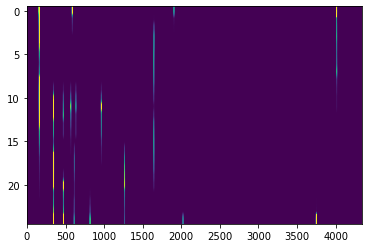


Image was predicted to be Cosmic but is actually Noise


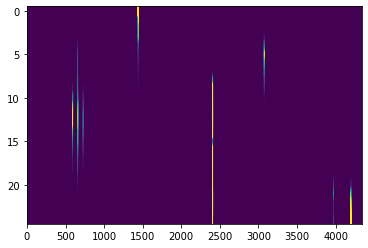


Image was predicted to be Cosmic but is actually Noise


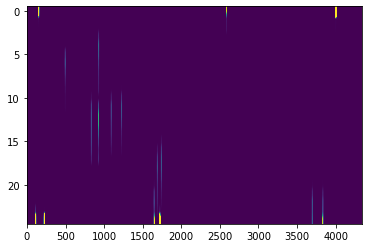


Image was predicted to be Cosmic but is actually Noise


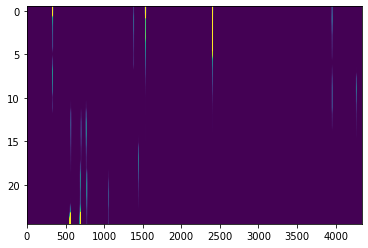


Image was predicted to be Cosmic but is actually Noise


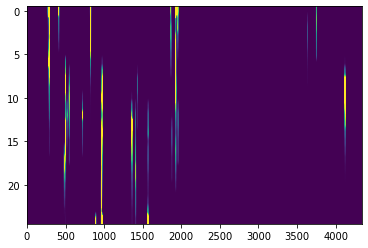


Image was predicted to be Cosmic but is actually Noise


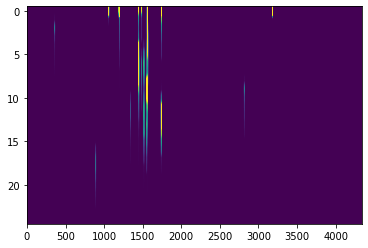


Image was predicted to be Cosmic but is actually Noise


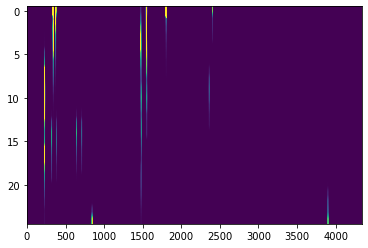


Image was predicted to be Cosmic but is actually Noise


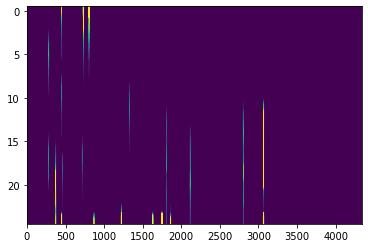


Image was predicted to be Cosmic but is actually Noise


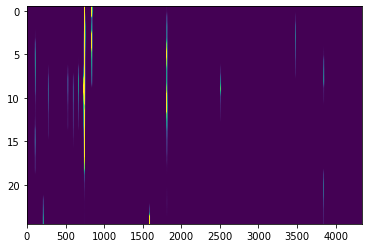


Image was predicted to be Cosmic but is actually Noise


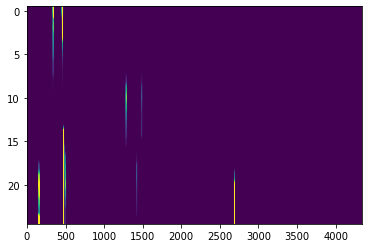

In [ ]:
plotIncorrect(incorrectly_pred_imgs, predictions, incorrect_indices, nImgs=10, startInd=0)

In [ ]:
https://medium.com/swlh/dump-keras-imagedatagenerator-start-using-tensorflow-tf-data-part-1-a30330bdbca9

import os
img_dims = [25, 4339]

def load_data_using_tfdata(folders):
    """
    Load the images in batches using Tensorflow (tfdata).
    Cache can be used to speed up the process.
    Faster method in comparison to image loading using Keras.
    Returns:
    Data Generator to be used while training the model.
    """
    def parse_image(file_path):
        # convert the path to a list of path components
        parts = tf.strings.split(file_path, os.path.sep)
        class_names = np.array(os.listdir(dir_path + ''))
        # The second to last is the class-directory
        label = parts[-2] == class_names
        # load the raw data from the file as a string
        img = tf.io.read_file(file_path)
        # convert the compressed string to a 3D uint8 tensor
        img = tf.image.decode_jpeg(img, channels=3)
        # Use `convert_image_dtype` to convert to floats in the [0,1] range
        img = tf.image.convert_image_dtype(img, tf.float32)
        # resize the image to the desired size.
        img = tf.image.resize(img, [img_dims[0], img_dims[1]])
        return img, label

    def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
        # If a small dataset, only load it once, and keep it in memory.
        # use `.cache(filename)` to cache preprocessing work for datasets
        # that don't fit in memory.
        if cache:
            if isinstance(cache, str):
                ds = ds.cache(cache)
            else:
                ds = ds.cache()
        ds = ds.shuffle(buffer_size=shuffle_buffer_size)
        # Repeat forever
        ds = ds.repeat()
        ds = ds.batch(batch_size)
        # `prefetch` lets the dataset fetch batches in the background
        # while the model is training.
        ds = ds.prefetch(buffer_size=AUTOTUNE)
        return ds

    data_generator = {}
    for x in folders:
        dir_extend = dir_path + '' + x
        print(dir_extend)
        list_ds = tf.data.Dataset.list_files(str(dir_extend+'*/*'))
        AUTOTUNE = tf.data.experimental.AUTOTUNE
        # Set `num_parallel_calls` so that multiple images are
        # processed in parallel
        labeled_ds = list_ds.map(
            parse_image, num_parallel_calls=AUTOTUNE)
        # cache = True, False, './file_name'
        # If the dataset doesn't fit in memory use a cache file,
        # eg. cache='./data.tfcache'
        data_generator[x] = prepare_for_training(
            labeled_ds, cache='./data.tfcache')

    return data_generator


def timeit(ds, steps=1000):
        """
        Check performance/speed for loading images using Keras or tfdata.
        """
        start = time.time()
        it = iter(ds)
        for i in range(steps):
            next(it)
            print('   >> ', i, '/1000', end='\r')
        duration = time.time()-start
        print(f'''{steps} batches: '''
                f'''{datetime.timedelta(seconds=int(duration))}''')
        print(f'{round(batch_size*steps/duration)} Images/s')
